In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No closing price CNN Images Experiments - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


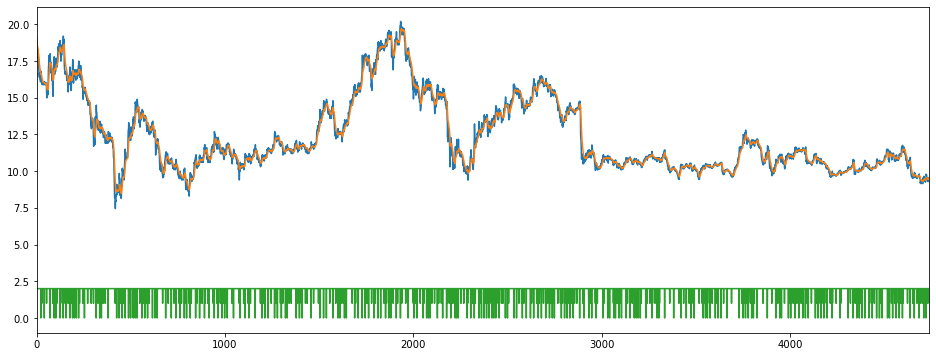

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0

In [8]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4725, 15, 1)

In [10]:
# price_data = np.array(price_data)
# price_data.shape

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4725, 15, 1)

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4725, 15, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4725, 64, 64, 1)

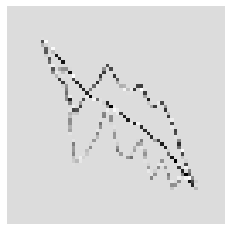

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.325581395348837, 1: 7.411764705882353, 2: 0.36649214659685864}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.6120 - accuracy: 0.6484 - mse: 5.6499 - weighted_accuracy: 0.3063 - weighted_mse: 6.1652WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 24ms/step - loss: 0.2478 - accuracy: 0.3585 - mse: 1.7495 - weighted_accuracy: 0.3387 - weighted_mse: 1.8125 - val_loss: 0.2046 - val_accuracy: 0.4286 - val_mse: 0.7953 - val_weighted_accuracy: 0.4286 - val_weighted_mse: 0.7953
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2081 - accuracy: 0.4243 - mse: 1.1022 - weighted_accuracy: 0.3301 - weighted_mse: 1.1429 - val_loss: 0.1870 - val_accuracy: 0.9090 - va

Epoch 27/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1982 - accuracy: 0.3717 - mse: 1.1683 - weighted_accuracy: 0.3642 - weighted_mse: 1.1681 - val_loss: 0.1984 - val_accuracy: 0.0677 - val_mse: 0.9637 - val_weighted_accuracy: 0.0677 - val_weighted_mse: 0.9637
Epoch 28/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1984 - accuracy: 0.3352 - mse: 1.1609 - weighted_accuracy: 0.3692 - weighted_mse: 1.1780 - val_loss: 0.2040 - val_accuracy: 0.0751 - val_mse: 0.8813 - val_weighted_accuracy: 0.0751 - val_weighted_mse: 0.8813
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1978 - accuracy: 0.3111 - mse: 1.1800 - weighted_accuracy: 0.3641 - weighted_mse: 1.1971 - val_loss: 0.1881 - val_accuracy: 0.6042 - val_mse: 0.9568 - val_weighted_accuracy: 0.6042 - val_weighted_mse: 0.9568
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1952 - accuracy: 0.3471 - mse: 1.1801 - weighted_accuracy: 0.4091 - weig

Epoch 56/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1860 - accuracy: 0.2447 - mse: 1.2486 - weighted_accuracy: 0.4546 - weighted_mse: 1.2348 - val_loss: 0.1956 - val_accuracy: 0.1418 - val_mse: 0.9498 - val_weighted_accuracy: 0.1418 - val_weighted_mse: 0.9498
Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1859 - accuracy: 0.1950 - mse: 1.2147 - weighted_accuracy: 0.4717 - weighted_mse: 1.1810 - val_loss: 0.1923 - val_accuracy: 0.1344 - val_mse: 1.0557 - val_weighted_accuracy: 0.1344 - val_weighted_mse: 1.0557
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1854 - accuracy: 0.2286 - mse: 1.2616 - weighted_accuracy: 0.4488 - weighted_mse: 1.2367 - val_loss: 0.1904 - val_accuracy: 0.1873 - val_mse: 1.0331 - val_weighted_accuracy: 0.1873 - val_weighted_mse: 1.0331
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1841 - accuracy: 0.2135 - mse: 1.2132 - weighted_accuracy: 0.4564 - we

Epoch 85/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1692 - accuracy: 0.1952 - mse: 1.3375 - weighted_accuracy: 0.5326 - weighted_mse: 1.3091 - val_loss: 0.1881 - val_accuracy: 0.2148 - val_mse: 1.1406 - val_weighted_accuracy: 0.2148 - val_weighted_mse: 1.1406
Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1674 - accuracy: 0.1881 - mse: 1.3546 - weighted_accuracy: 0.5393 - weighted_mse: 1.3283 - val_loss: 0.1963 - val_accuracy: 0.1566 - val_mse: 1.1452 - val_weighted_accuracy: 0.1566 - val_weighted_mse: 1.1452
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1719 - accuracy: 0.1828 - mse: 1.3209 - weighted_accuracy: 0.5134 - weighted_mse: 1.2697 - val_loss: 0.1989 - val_accuracy: 0.1175 - val_mse: 1.2023 - val_weighted_accuracy: 0.1175 - val_weighted_mse: 1.2023
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1691 - accuracy: 0.1728 - mse: 1.3221 - weighted_accuracy: 0.5336 - weig

Epoch 114/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1491 - accuracy: 0.2241 - mse: 1.5355 - weighted_accuracy: 0.6286 - weighted_mse: 1.4850 - val_loss: 0.1903 - val_accuracy: 0.2370 - val_mse: 1.3572 - val_weighted_accuracy: 0.2370 - val_weighted_mse: 1.3572
Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1500 - accuracy: 0.2384 - mse: 1.5611 - weighted_accuracy: 0.6228 - weighted_mse: 1.5300 - val_loss: 0.1802 - val_accuracy: 0.3407 - val_mse: 1.3578 - val_weighted_accuracy: 0.3407 - val_weighted_mse: 1.3578
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1484 - accuracy: 0.2352 - mse: 1.5447 - weighted_accuracy: 0.6493 - weighted_mse: 1.5093 - val_loss: 0.1922 - val_accuracy: 0.2360 - val_mse: 1.4029 - val_weighted_accuracy: 0.2360 - val_weighted_mse: 1.4029
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1480 - accuracy: 0.2593 - mse: 1.5373 - weighted_accuracy: 0.6359 

Epoch 143/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1363 - accuracy: 0.3619 - mse: 1.8044 - weighted_accuracy: 0.6737 - weighted_mse: 1.8830 - val_loss: 0.1832 - val_accuracy: 0.4000 - val_mse: 1.6373 - val_weighted_accuracy: 0.4000 - val_weighted_mse: 1.6373
Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1360 - accuracy: 0.3759 - mse: 1.7851 - weighted_accuracy: 0.6789 - weighted_mse: 1.8557 - val_loss: 0.1760 - val_accuracy: 0.4201 - val_mse: 1.5403 - val_weighted_accuracy: 0.4201 - val_weighted_mse: 1.5403
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1310 - accuracy: 0.3582 - mse: 1.8267 - weighted_accuracy: 0.6946 - weighted_mse: 1.9174 - val_loss: 0.1819 - val_accuracy: 0.4000 - val_mse: 1.6505 - val_weighted_accuracy: 0.4000 - val_weighted_mse: 1.6505
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1301 - accuracy: 0.3899 - mse: 1.8733 - weighted_accuracy: 0.7080 - 

Epoch 172/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1164 - accuracy: 0.5061 - mse: 2.0899 - weighted_accuracy: 0.7359 - weighted_mse: 2.4192 - val_loss: 0.1636 - val_accuracy: 0.5418 - val_mse: 1.7060 - val_weighted_accuracy: 0.5418 - val_weighted_mse: 1.7060
Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1172 - accuracy: 0.5005 - mse: 2.0997 - weighted_accuracy: 0.7302 - weighted_mse: 2.4506 - val_loss: 0.1612 - val_accuracy: 0.5566 - val_mse: 1.7982 - val_weighted_accuracy: 0.5566 - val_weighted_mse: 1.7982
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1151 - accuracy: 0.5021 - mse: 2.1281 - weighted_accuracy: 0.7455 - weighted_mse: 2.4362 - val_loss: 0.1581 - val_accuracy: 0.5862 - val_mse: 1.7565 - val_weighted_accuracy: 0.5862 - val_weighted_mse: 1.7565
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1176 - accuracy: 0.5333 - mse: 2.1610 - weighted_accuracy: 0.7292 - 

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14584428071975708
Test accuracy: 0.6571428775787354


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[ 0.12926117 -2.5114343  -0.8058108 ]
 [-0.6120813  -1.7117374  -0.29517156]
 [-2.6243389   0.10301885 -0.81824875]
 ...
 [-1.4220493  -1.2886431  -0.03188305]
 [-1.392758   -0.9431439  -0.12769106]
 [-1.2857271  -1.2505565  -0.06374957]]


Counter({0: 140, 2: 654, 1: 151})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 859, 0: 43, 1: 43})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) 

number of predictions: 945
actual predicted buys: 14
actual buys but predicted sell: 2
actual buys but predicted hold: 27
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 31
actual holds but predicted buy: 136
actual holds but predicted sell: 127
actual predicted holds: 596
Percentage buys correct: 32.55813953488372%
Percentage sells correct: 25.58139534883721%
Percentage holds correct: 69.38300349243306%
actual buys: 43
actual sells: 43
actual holds: 859


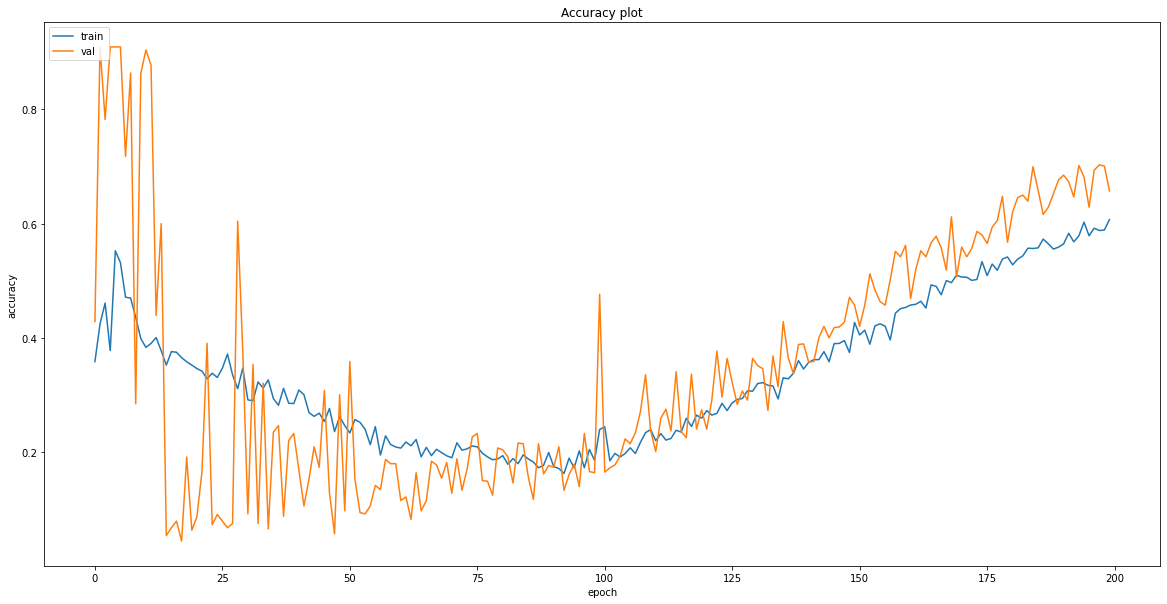

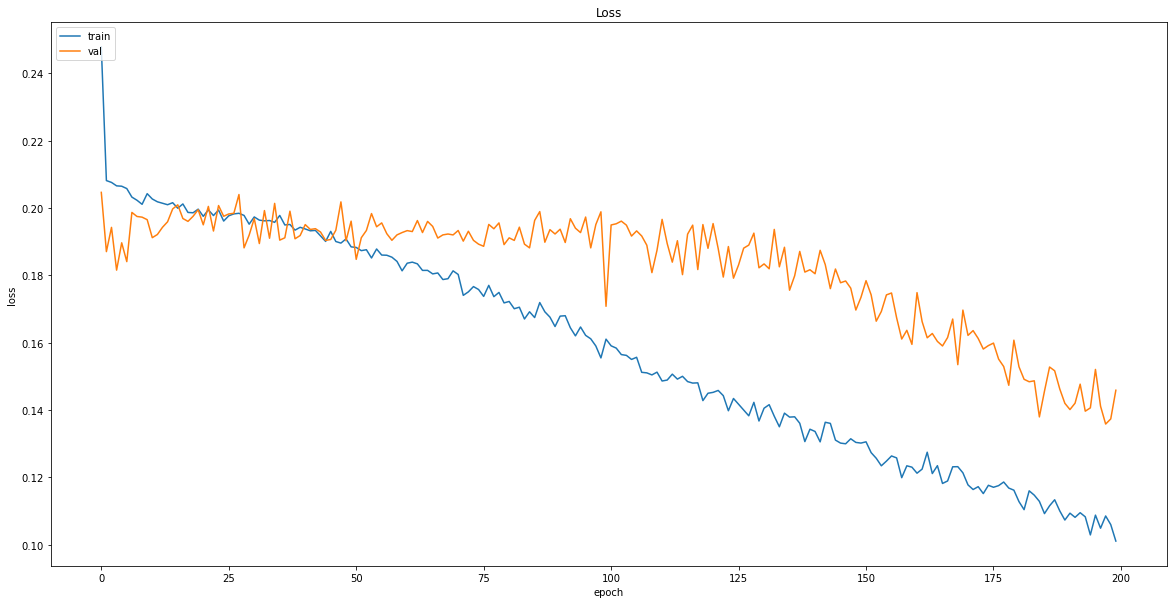

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('Singapore_Airlines_image_cnn_buy_hold_sell_no_close.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/Singapore_Airlines_image_cnn_buy_hold_sell_no_close.model\assets


### Test Performance

### non-recession

In [28]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [29]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


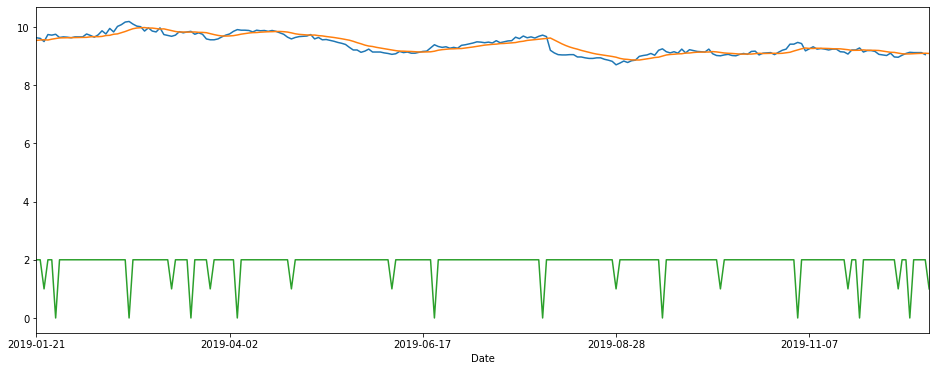

In [30]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [31]:
# willr_data = []
# # price_data = []
# ema_data = []
# obv_data = []
# labels = []
# # data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         # data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         # data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         # data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [32]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [33]:
willr_data = np.array(willr_data)
# price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [35]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [36]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [37]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 10ms/step - loss: 0.1509 - accuracy: 0.6147 - mean_squared_error: 2.0168 - weighted_accuracy: 0.6147 - weighted_mean_squared_error: 2.0168
Test loss: 0.1509271264076233
Test accuracy: 0.6146789193153381


In [38]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 138, 0: 42, 1: 38})

In [39]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [40]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [41]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2019-02-11         9.71  9.662247 -15.151533  6464788.0     2.0            2   
2019-02-12         9.65  9.669594 -30.303065  5675088.0     2.0            0   
2019-02-13         9.73  9.666579 -48.484962  4337188.0     2.0            2   
2019-02-14         9.87  9.676336 -32.000351  5826588.0     2.0            2   
2019-02-15         9.76  9.706131  -6.250130  8384988.0     2.0            0   

            actual  
Date                
2019-02-11       2  
2019-02-12       2  
2019-02-13       2  
2019-02-14       2  
2019-02-15       2

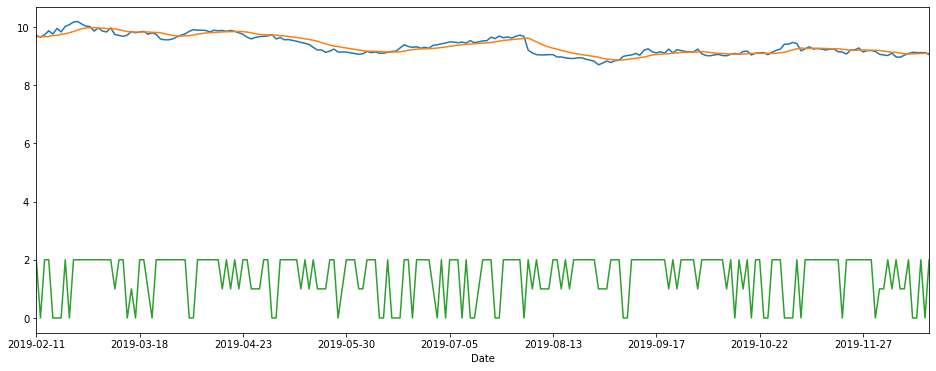

In [42]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

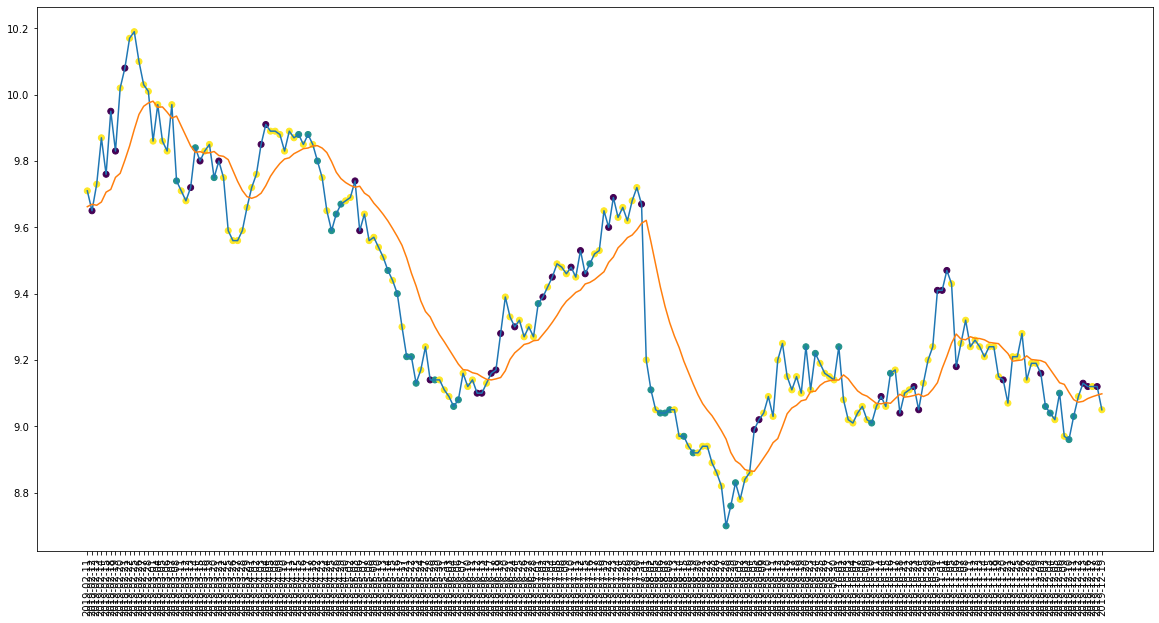

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

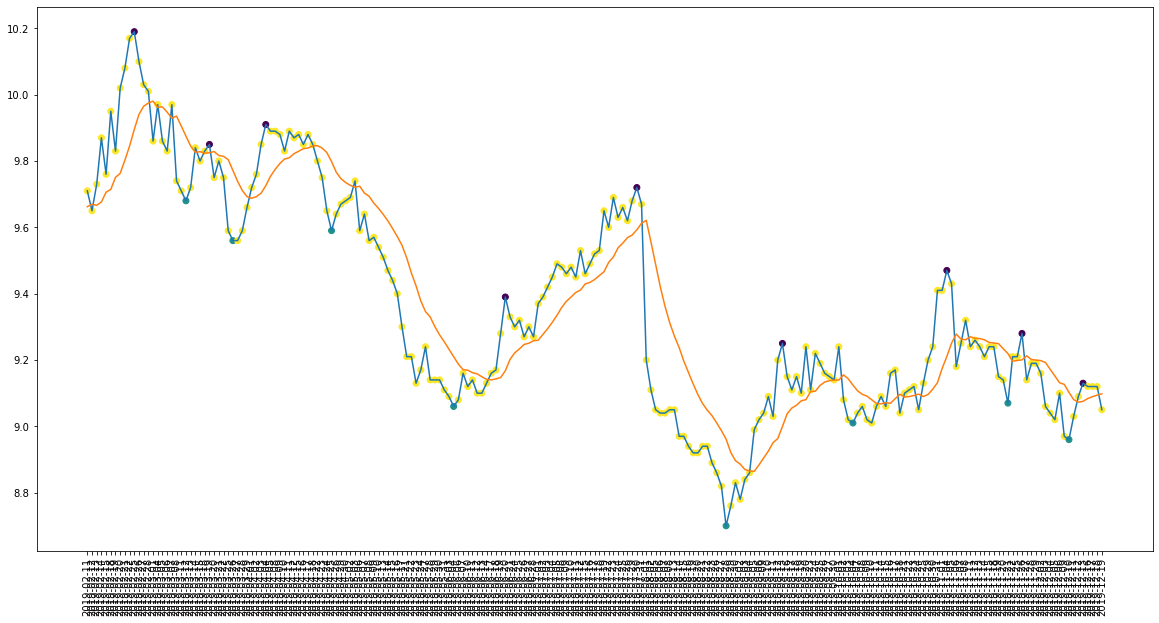

In [44]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [45]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 34
actual holds but predicted sell: 39
actual predicted holds: 127
Percentage buys correct: 44.44444444444444%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 63.5%
actual buys: 9
actual sells: 9
actual holds: 200


In [46]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 52.63157894736842%
Percentage sells correct: 47.61904761904762%
Percentage holds correct: 81.02189781021897%


In [47]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.739999771118164
Shares owned at the moment: 1023
Cash capital at the moment: $8.579179790020135


Stop Loss Activated!

Share price: $9.470000267028807
Shares owned at the moment: 0
Cash capital at the moment: $9669.747974709271


Share price: $9.470000267028807
Shares owned at the moment: 1018
Cash capital at the moment: $2.7764371263983776


Stop Loss Activated!

Share price: $9.210000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9352.773080853223


Share price: $9.210000038146973
Shares owned at the moment: 1012
Cash capital at the moment: $6.621612142324011


Stop Loss Activated!

Share price: $8.9399995803833
Shares owned at the moment: 0
Cash capital at the moment: $9029.021168658017


Share price: $8.920000076293945
Shares owned at the moment: 1009
Cash capital at the moment: $3.9903214657297212


Price increase from previously bought: 5.2039600395675345%
Share price: $9.40999984741211
Shares owned at the moment: 0
Cash capital at the momen

In [48]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9269.197226061342
profit gained: -7.30802773938658%


In [49]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys        correct_sells correct_holds  \
0       0.614679  44.44444444444444%  33.333333333333336%         63.5%   

     correct_low_buys  correct_high_sells   correct_mid_holds  \
0  52.63157894736842%  47.61904761904762%  81.02189781021897%   

         Profit gained   buy_n_hold profit  
0  -5.897446748158945%  -7.30802773938658%

### Recession

In [50]:
logger = []

In [51]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


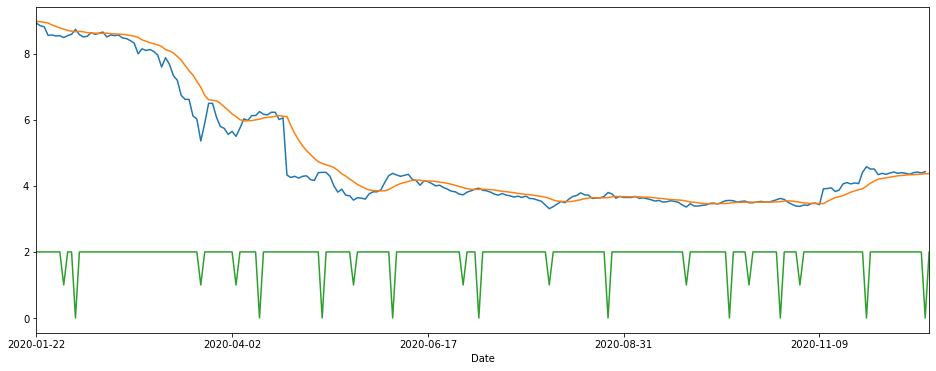

In [52]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [53]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [54]:
willr_data = np.array(willr_data)
# price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [56]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [57]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [58]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 14ms/step - loss: 0.1476 - accuracy: 0.6326 - mean_squared_error: 1.9206 - weighted_accuracy: 0.6326 - weighted_mean_squared_error: 1.9206
Test loss: 0.147600457072258
Test accuracy: 0.6325581669807434


In [59]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 137, 0: 24, 1: 54})

In [60]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [61]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [62]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-12         8.64  8.623953 -86.440694 -2356000.0     2.0            2   
2020-02-13         8.59  8.626421 -61.224363  -575600.0     2.0            2   
2020-02-14         8.62  8.620818 -64.102508 -2132700.0     2.0            2   
2020-02-17         8.66  8.620692 -45.161340  -798700.0     2.0            2   
2020-02-18         8.51  8.626740 -32.258144   341600.0     2.0            0   

            actual  
Date                
2020-02-12       2  
2020-02-13       2  
2020-02-14       2  
2020-02-17       2  
2020-02-18       2

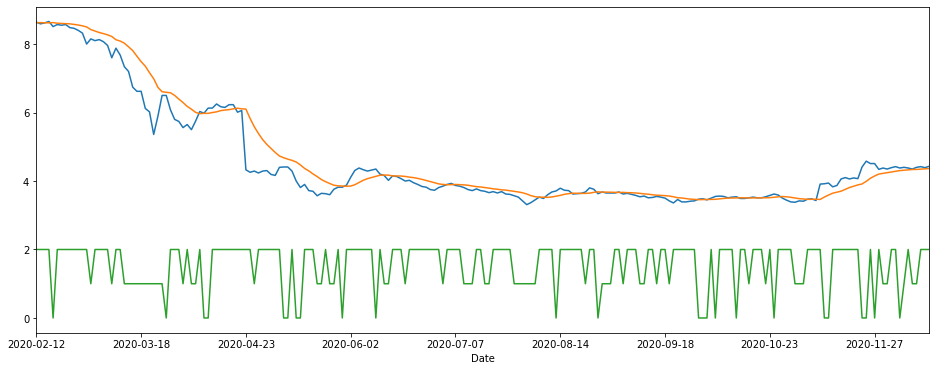

In [63]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

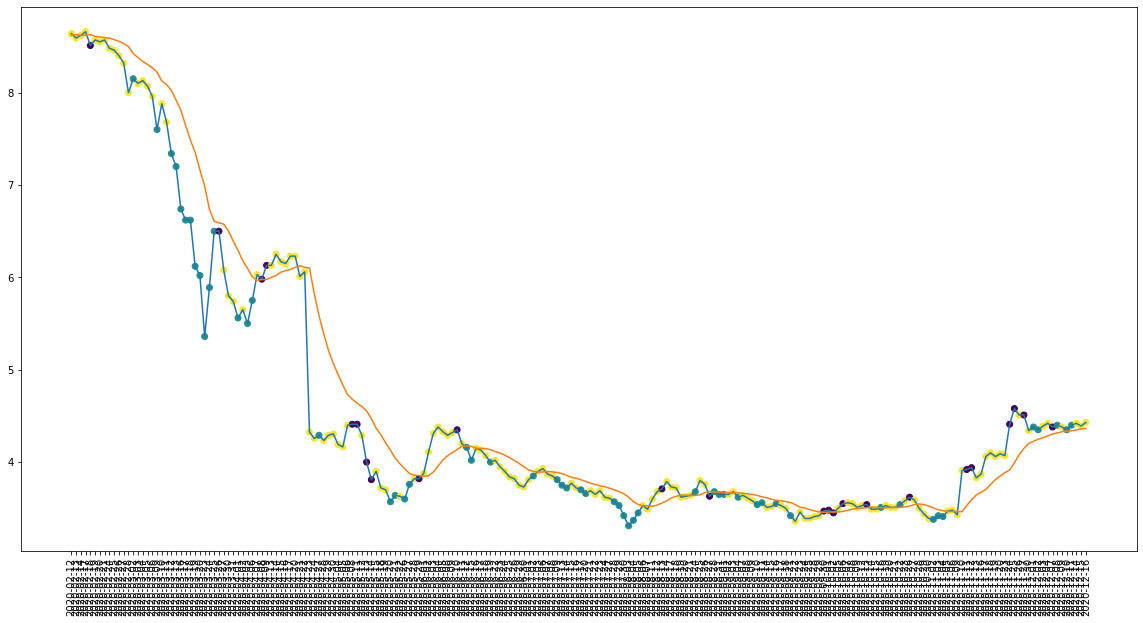

In [64]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

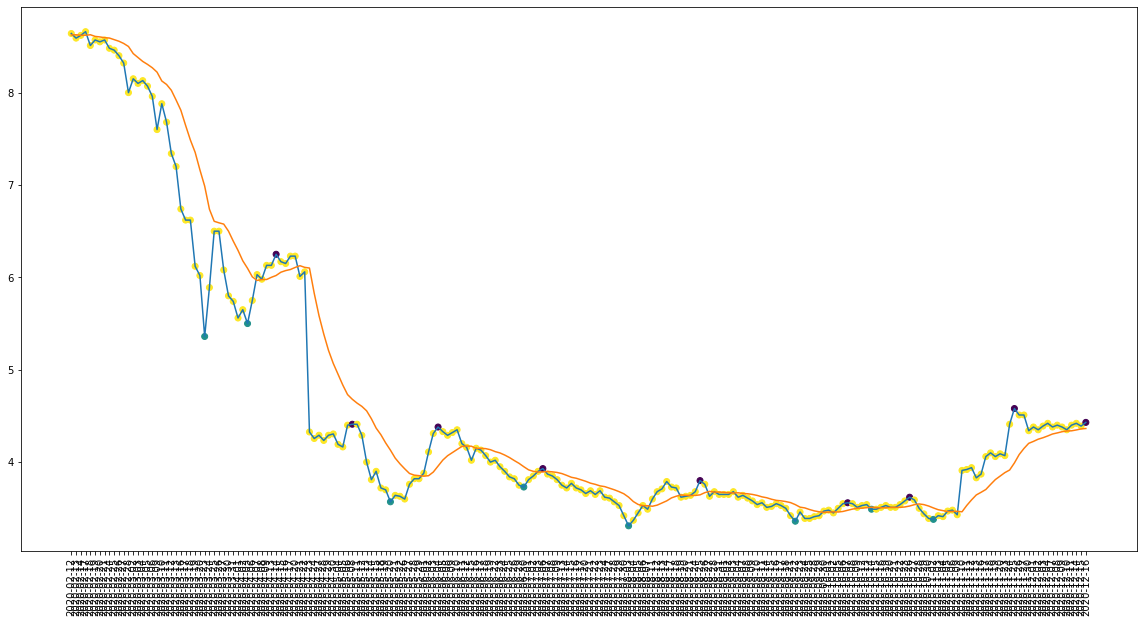

In [65]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [66]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 49
actual holds but predicted sell: 21
actual predicted holds: 128
Percentage buys correct: 62.5%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 64.64646464646465%
actual buys: 8
actual sells: 9
actual holds: 198


In [67]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[8.479999542236326, 8.510000228881836, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.100000381469728, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219]
Percentage buys correct: 61.111111111111114%
Percentage sells correct: 66.66666666666667%
Percentage holds correct: 86.76470588235294%


In [68]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.149999618530272
Shares owned at the moment: 1223
Cash capital at the moment: $5.139980320454924


Stop Loss Activated!

Share price: $7.599999904632567
Shares owned at the moment: 0
Cash capital at the moment: $9274.379164006828


Share price: $7.599999904632567
Shares owned at the moment: 1216
Cash capital at the moment: $7.364880292536327


Stop Loss Activated!

Share price: $7.3400001525878915
Shares owned at the moment: 0
Cash capital at the moment: $8908.260105329158


Share price: $7.3400001525878915
Shares owned at the moment: 1210
Cash capital at the moment: $2.436070190071405


Stop Loss Activated!

Share price: $6.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $8135.408444004654


Share price: $6.739999771118164
Shares owned at the moment: 1203
Cash capital at the moment: $4.891115106700454


Stop Loss Activated!

Share price: $6.119999885559082
Shares owned at the moment: 0
Cash capital at the moment: $7347.004487812875


Share pric

In [69]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5100.181760163545
profit gained: -48.998182398364555%


In [70]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys        correct_sells       correct_holds  \
0       0.614679  44.44444444444444%  33.333333333333336%               63.5%   
1       0.632558               62.5%  33.333333333333336%  64.64646464646465%   

      correct_low_buys  correct_high_sells   correct_mid_holds  \
0   52.63157894736842%  47.61904761904762%  81.02189781021897%   
1  61.111111111111114%  66.66666666666667%  86.76470588235294%   

          Profit gained     buy_n_hold profit  
0   -5.897446748158945%    -7.30802773938658%  
1  -16.343050759745328%  -48.998182398364555%

### OCBC Bank

In [71]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


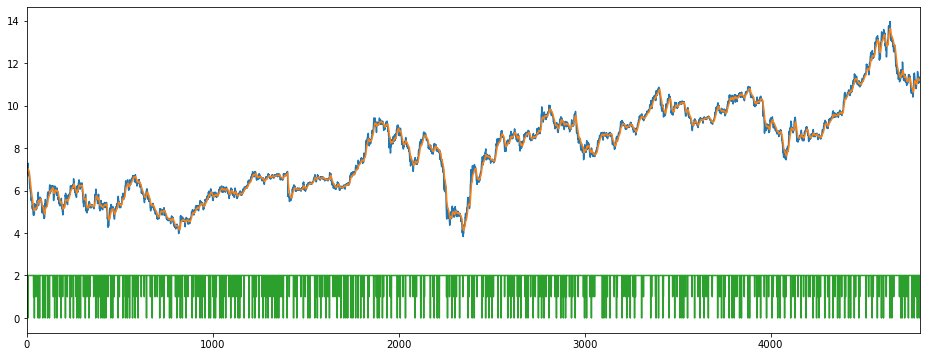

In [72]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [73]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0

In [74]:
# willr_data = []
# # price_data = []
# ema_data = []
# obv_data = []
# labels = []
# # data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         # data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         # data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         # data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [75]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [76]:
willr_data = np.array(willr_data)
# price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [78]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4789, 64, 64, 1)

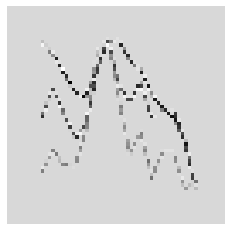

In [79]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [80]:
X = X/255

In [81]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [82]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [83]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [84]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [85]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.255681818181818, 1: 7.931677018633541, 2: 0.3654836863194047}
Epoch 1/200
30/30 [==============================] - 9s 292ms/step - loss: 0.2479 - accuracy: 0.3440 - mse: 1.7144 - weighted_accuracy: 0.3302 - weighted_mse: 1.6958 - val_loss: 0.1930 - val_accuracy: 0.0574 - val_mse: 1.0453 - val_weighted_accuracy: 0.0574 - val_weighted_mse: 1.0453
Epoch 2/200
30/30 [==============================] - 0s 14ms/step - loss: 0.2050 - accuracy: 0.2553 - mse: 1.2182 - weighted_accuracy: 0.3441 - weighted_mse: 1.1985 - val_loss: 0.2045 - val_accuracy: 0.0449 - val_mse: 0.9531 - val_weighted_accuracy: 0.0449 - val_weighted_mse: 0.9531
Epoch 3/200
30/30 [==============================] - 0s 14ms/step - loss: 0.2063 - accuracy: 0.2263 - mse: 1.1792 - weighted_accuracy: 0.3500 - weighted_mse: 1.1551 - val_loss: 0.2077 - val_accuracy: 0.0480 - val_mse: 0.9229 - val_weighted_accuracy: 0.0480 - val_weighted_mse: 0.9229
Epoch 4/200
30/30 [==============================] - 0s 14ms/step - loss: 0.202

30/30 [==============================] - 0s 14ms/step - loss: 0.1887 - accuracy: 0.2485 - mse: 1.2455 - weighted_accuracy: 0.4883 - weighted_mse: 1.2048 - val_loss: 0.1996 - val_accuracy: 0.0678 - val_mse: 1.0303 - val_weighted_accuracy: 0.0678 - val_weighted_mse: 1.0303
Epoch 29/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1836 - accuracy: 0.2420 - mse: 1.2875 - weighted_accuracy: 0.4793 - weighted_mse: 1.2346 - val_loss: 0.2005 - val_accuracy: 0.0741 - val_mse: 1.2486 - val_weighted_accuracy: 0.0741 - val_weighted_mse: 1.2486
Epoch 30/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1868 - accuracy: 0.2412 - mse: 1.2809 - weighted_accuracy: 0.5061 - weighted_mse: 1.1842 - val_loss: 0.2023 - val_accuracy: 0.0804 - val_mse: 1.0801 - val_weighted_accuracy: 0.0804 - val_weighted_mse: 1.0801
Epoch 31/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1862 - accuracy: 0.2751 - mse: 1.2971 - weighted_accuracy: 0.5056 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1652 - accuracy: 0.1812 - mse: 1.5082 - weighted_accuracy: 0.5735 - weighted_mse: 1.4381 - val_loss: 0.2060 - val_accuracy: 0.0825 - val_mse: 1.3642 - val_weighted_accuracy: 0.0825 - val_weighted_mse: 1.3642
Epoch 58/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1645 - accuracy: 0.1770 - mse: 1.5559 - weighted_accuracy: 0.5886 - weighted_mse: 1.5013 - val_loss: 0.2034 - val_accuracy: 0.1169 - val_mse: 1.2685 - val_weighted_accuracy: 0.1169 - val_weighted_mse: 1.2685
Epoch 59/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1615 - accuracy: 0.1859 - mse: 1.5258 - weighted_accuracy: 0.6174 - weighted_mse: 1.4652 - val_loss: 0.2062 - val_accuracy: 0.1148 - val_mse: 1.3648 - val_weighted_accuracy: 0.1148 - val_weighted_mse: 1.3648
Epoch 60/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1642 - accuracy: 0.1851 - mse: 1.5232 - weighted_accuracy: 0.5972 - 

Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1466 - accuracy: 0.2323 - mse: 1.6791 - weighted_accuracy: 0.6551 - weighted_mse: 1.7227 - val_loss: 0.1980 - val_accuracy: 0.2004 - val_mse: 1.3352 - val_weighted_accuracy: 0.2004 - val_weighted_mse: 1.3352
Epoch 87/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1464 - accuracy: 0.2438 - mse: 1.6658 - weighted_accuracy: 0.6507 - weighted_mse: 1.7124 - val_loss: 0.1965 - val_accuracy: 0.2035 - val_mse: 1.3803 - val_weighted_accuracy: 0.2035 - val_weighted_mse: 1.3803
Epoch 88/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1436 - accuracy: 0.2307 - mse: 1.7657 - weighted_accuracy: 0.6523 - weighted_mse: 1.7789 - val_loss: 0.1993 - val_accuracy: 0.2088 - val_mse: 1.4569 - val_weighted_accuracy: 0.2088 - val_weighted_mse: 1.4569
Epoch 89/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1435 - accuracy: 0.2352 - mse: 1.7202 - weighted_accuracy: 0.6660 - 

30/30 [==============================] - 0s 10ms/step - loss: 0.1296 - accuracy: 0.3863 - mse: 1.9061 - weighted_accuracy: 0.7200 - weighted_mse: 2.0993 - val_loss: 0.1834 - val_accuracy: 0.3528 - val_mse: 1.6541 - val_weighted_accuracy: 0.3528 - val_weighted_mse: 1.6541
Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1312 - accuracy: 0.3675 - mse: 1.9193 - weighted_accuracy: 0.6980 - weighted_mse: 2.1617 - val_loss: 0.1903 - val_accuracy: 0.3267 - val_mse: 1.6609 - val_weighted_accuracy: 0.3267 - val_weighted_mse: 1.6609
Epoch 116/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1315 - accuracy: 0.3709 - mse: 1.9413 - weighted_accuracy: 0.7045 - weighted_mse: 2.1360 - val_loss: 0.1869 - val_accuracy: 0.3434 - val_mse: 1.6744 - val_weighted_accuracy: 0.3434 - val_weighted_mse: 1.6744
Epoch 117/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1293 - accuracy: 0.3790 - mse: 1.9047 - weighted_accuracy: 0.7148 - weighted_m

Epoch 143/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1103 - accuracy: 0.5560 - mse: 2.2029 - weighted_accuracy: 0.7827 - weighted_mse: 2.7986 - val_loss: 0.1568 - val_accuracy: 0.5752 - val_mse: 1.8012 - val_weighted_accuracy: 0.5752 - val_weighted_mse: 1.8012
Epoch 144/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1119 - accuracy: 0.5727 - mse: 2.1902 - weighted_accuracy: 0.7696 - weighted_mse: 2.7596 - val_loss: 0.1609 - val_accuracy: 0.5626 - val_mse: 1.9035 - val_weighted_accuracy: 0.5626 - val_weighted_mse: 1.9035
Epoch 145/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1137 - accuracy: 0.5714 - mse: 2.1366 - weighted_accuracy: 0.7738 - weighted_mse: 2.6747 - val_loss: 0.1617 - val_accuracy: 0.5626 - val_mse: 1.9346 - val_weighted_accuracy: 0.5626 - val_weighted_mse: 1.9346
Epoch 146/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1106 - accuracy: 0.5740 - mse: 2.2517 - weighted_accuracy: 0.789

Epoch 172/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0905 - accuracy: 0.7022 - mse: 2.6639 - weighted_accuracy: 0.8358 - weighted_mse: 3.9595 - val_loss: 0.1447 - val_accuracy: 0.6701 - val_mse: 2.3686 - val_weighted_accuracy: 0.6701 - val_weighted_mse: 2.3686
Epoch 173/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0884 - accuracy: 0.7110 - mse: 2.6845 - weighted_accuracy: 0.8398 - weighted_mse: 3.9466 - val_loss: 0.1436 - val_accuracy: 0.6628 - val_mse: 2.1603 - val_weighted_accuracy: 0.6628 - val_weighted_mse: 2.1603
Epoch 174/200
30/30 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.7083 - mse: 2.6079 - weighted_accuracy: 0.8203 - weighted_mse: 3.842 - 0s 10ms/step - loss: 0.0939 - accuracy: 0.7037 - mse: 2.5951 - weighted_accuracy: 0.8168 - weighted_mse: 3.7571 - val_loss: 0.1369 - val_accuracy: 0.6858 - val_mse: 2.1344 - val_weighted_accuracy: 0.6858 - val_weighted_mse: 2.1344
Epoch 175/200
30/30 [=============

30/30 [==============================] - 0s 10ms/step - loss: 0.0737 - accuracy: 0.7779 - mse: 3.1341 - weighted_accuracy: 0.8719 - weighted_mse: 4.9303 - val_loss: 0.1307 - val_accuracy: 0.7244 - val_mse: 2.5940 - val_weighted_accuracy: 0.7244 - val_weighted_mse: 2.5940


In [86]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.1306750327348709
Test accuracy: 0.7244259119033813


In [87]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[ 0.39841133 -3.5081153  -0.9531915 ]
 [-1.7162281  -0.9737158  -0.46352804]
 [-2.2126758  -1.3323172   0.4744488 ]
 ...
 [-1.217511   -1.4700059  -0.05752714]
 [-0.47728348 -2.619165   -0.35847664]
 [-3.0687206  -0.50425076 -0.10266843]]


Counter({0: 140, 2: 741, 1: 77})

In [88]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 874, 1: 40, 0: 44})

In [89]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 958
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 31
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 34
actual holds but predicted buy: 67
actual holds but predicted sell: 131
actual predicted holds: 676
Percentage buys correct: 22.5%
Percentage sells correct: 20.454545454545453%
Percentage holds correct: 77.34553775743707%
actual buys: 40
actual sells: 44
actual holds: 874


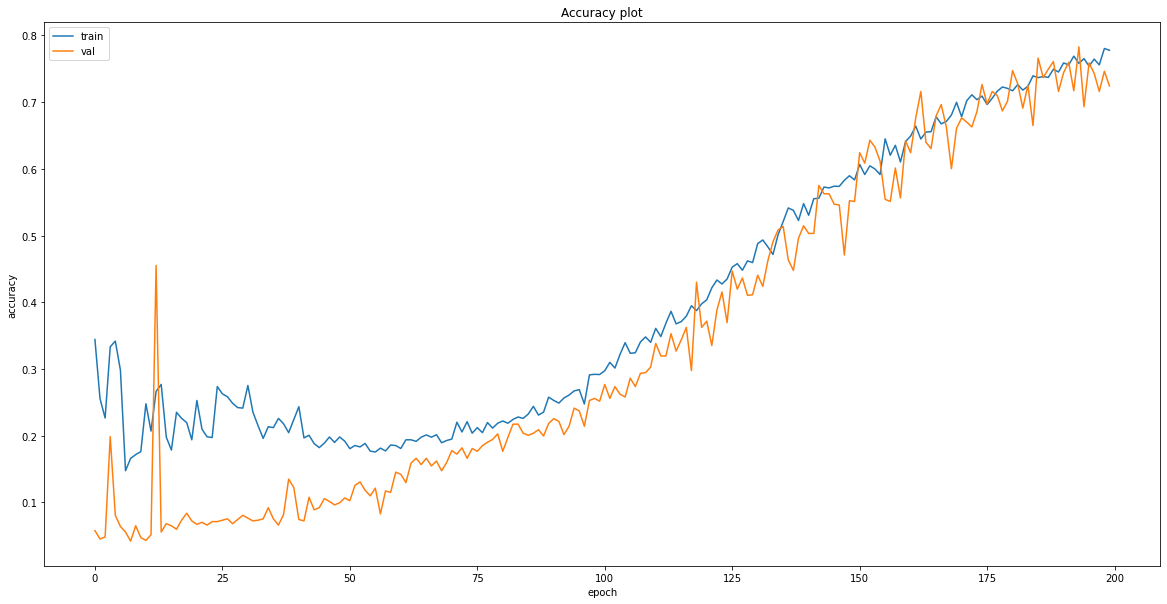

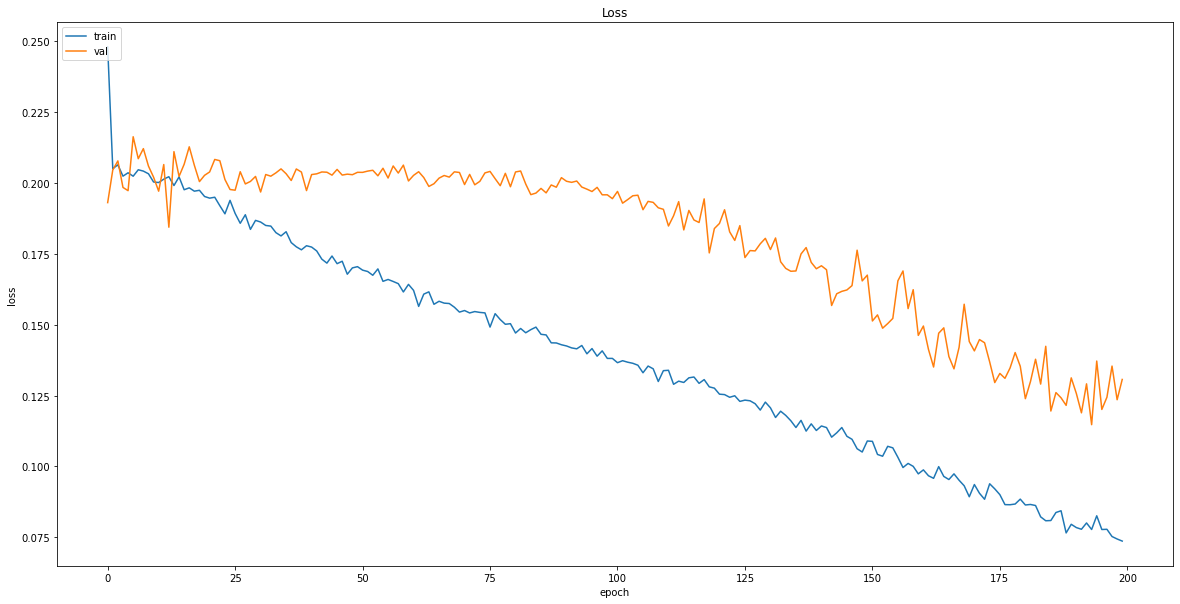

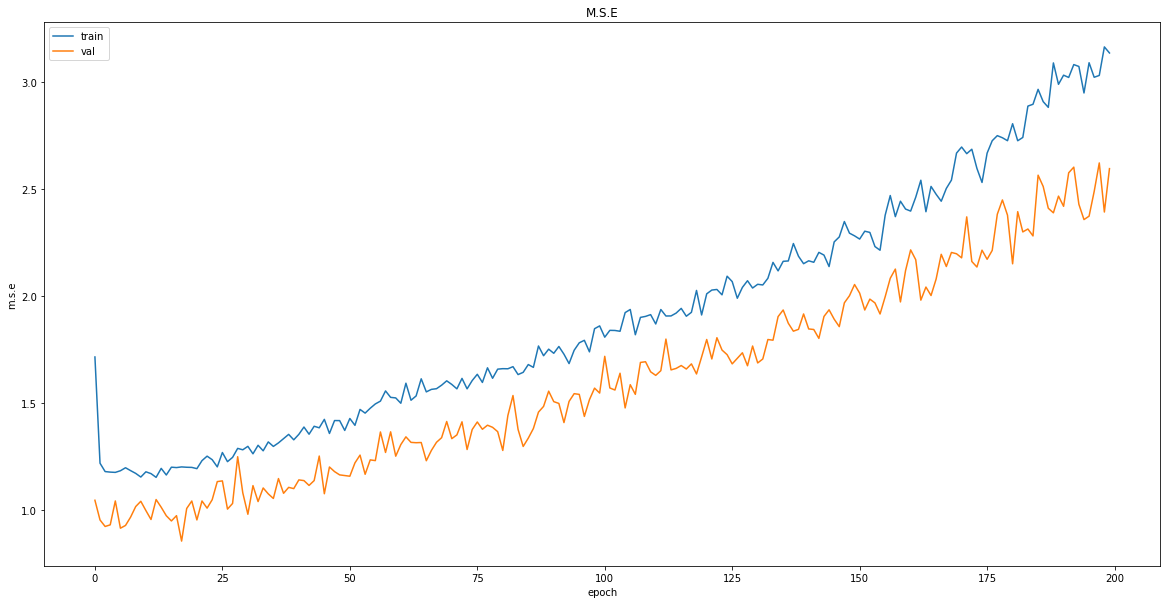

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [91]:
# Save model
model.save("models/{}".format('OCBC_image_cnn_buy_hold_sell_no_close.model'))

INFO:tensorflow:Assets written to: models/OCBC_image_cnn_buy_hold_sell_no_close.model\assets


### Test Performance

#### Non-Recession

In [92]:
logger = []

In [93]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


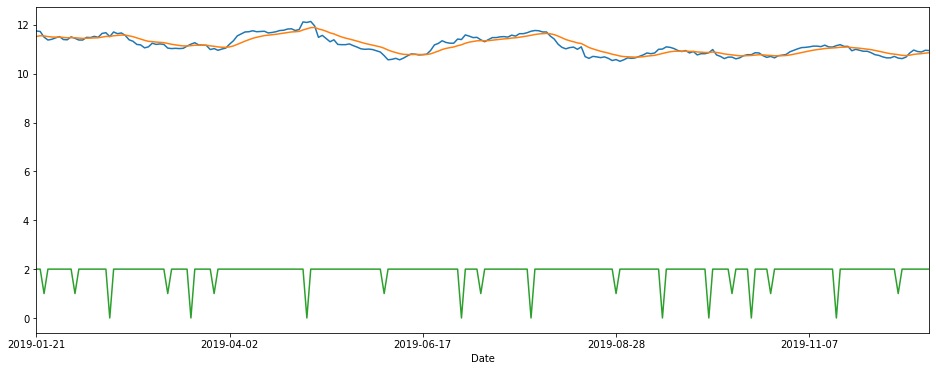

In [94]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

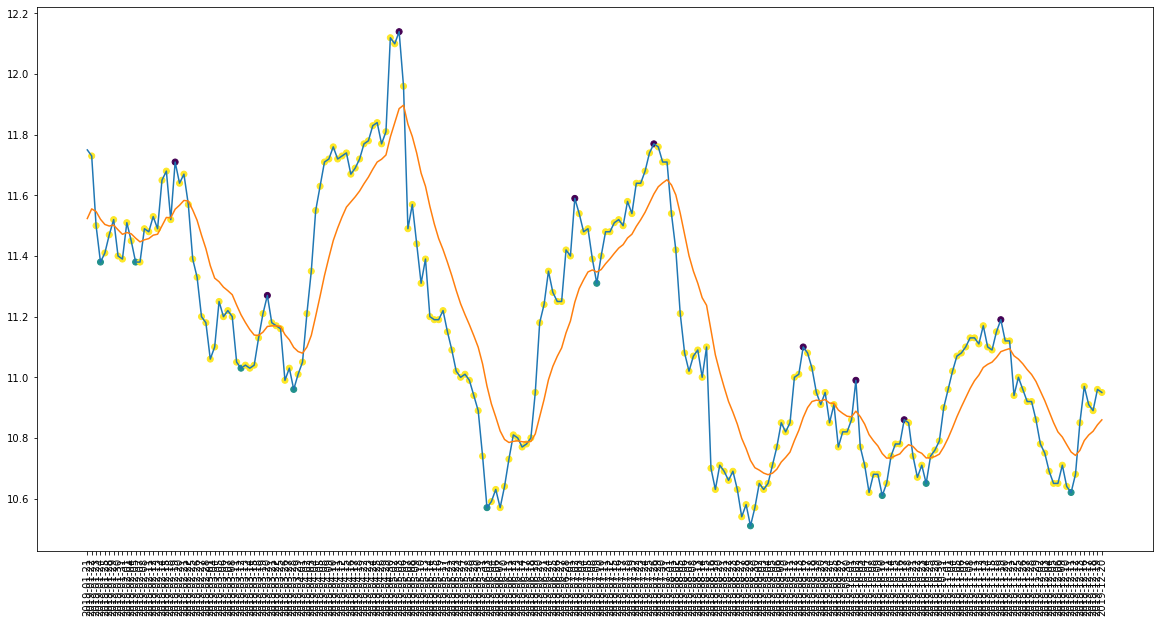

In [95]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [96]:
# willr_data = []
# # price_data = []
# ema_data = []
# obv_data = []
# labels = []
# # data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         # data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         # data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         # data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1
        
# willr_data = np.array(willr_data)
# # price_data = np.array(price_data)
# ema_data = np.array(ema_data)
# obv_data = np.array(obv_data)

In [97]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
# price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [99]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [100]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [101]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1267 - accuracy: 0.7018 - mean_squared_error: 2.6243 - weighted_accuracy: 0.7018 - weighted_mean_squared_error: 2.6243
Test loss: 0.12667962908744812
Test accuracy: 0.7018348574638367


In [102]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 160, 0: 37, 1: 21})

In [103]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [104]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [105]:
# df['previous_1d'] = df['previous_1d'].shift(-1)
# df.dropna(inplace=True)
# df = df.iloc[13:]
# df['predictions'] = predictions
# df['actual'] = actual
# df.head()

In [106]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        11.53  11.457507 -67.857228  17615658.0     2.0   
2019-02-12        11.49  11.468659 -43.902530  20832858.0     2.0   
2019-02-13        11.65  11.471942 -42.424356  17325458.0     2.0   
2019-02-14        11.68  11.499336 -10.256417  22091358.0     2.0   
2019-02-15        11.52  11.527130  -5.714153  24228358.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            2       2  
2019-02-13            0       2  
2019-02-14            2       2  
2019-02-15            2       2

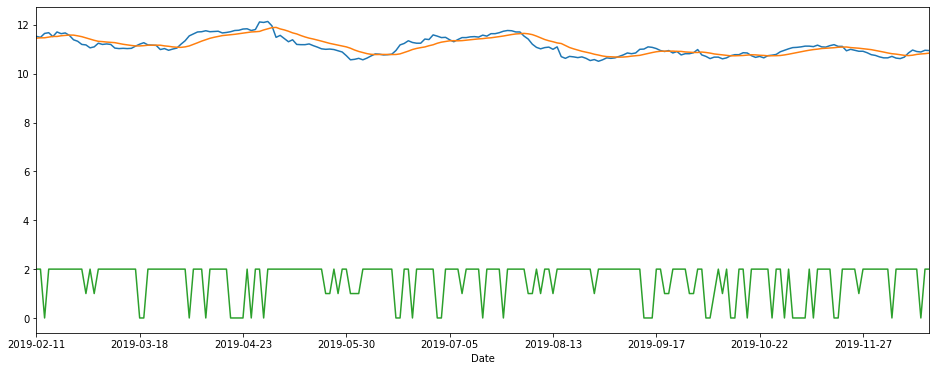

In [107]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

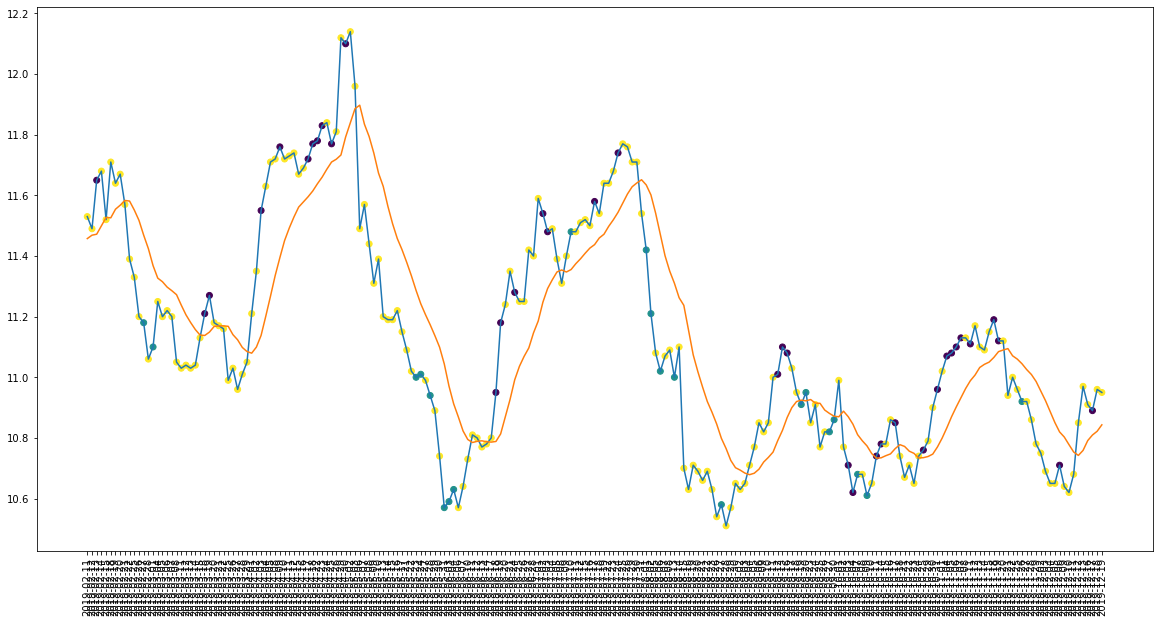

In [108]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

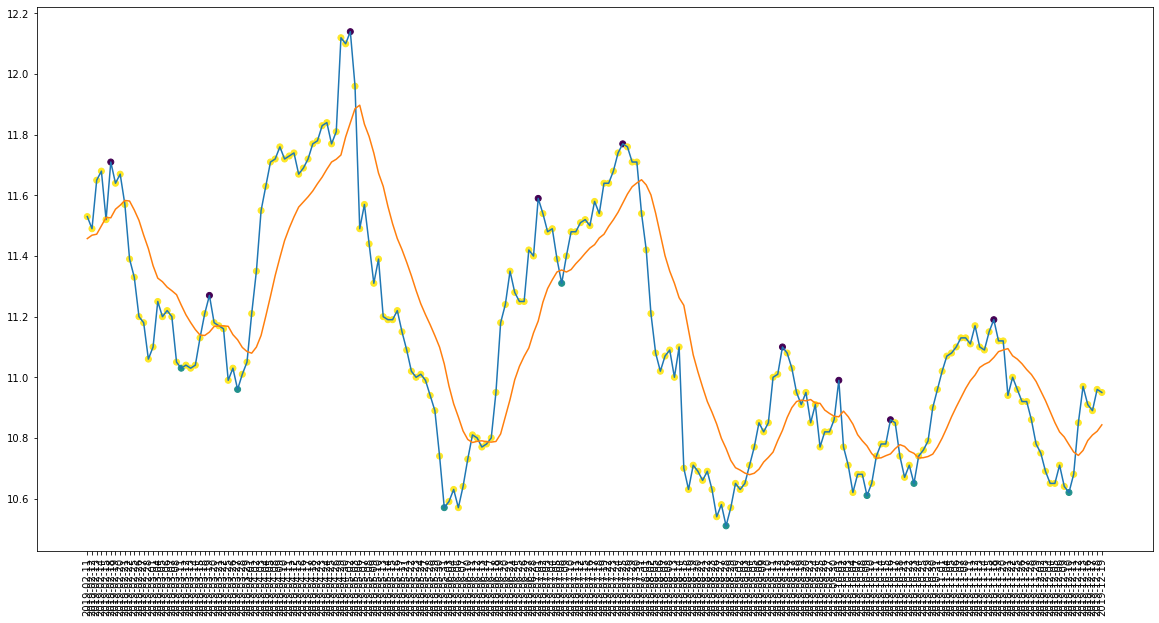

In [109]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [110]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 19
actual holds but predicted sell: 34
actual predicted holds: 148
Percentage buys correct: 25.0%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 73.6318407960199%
actual buys: 8
actual sells: 9
actual holds: 201


In [111]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 71.42857142857143%
Percentage sells correct: 59.45945945945946%
Percentage holds correct: 85.53459119496856%


In [112]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.18000030517578
Shares owned at the moment: 892
Cash capital at the moment: $0.015187034608970862


Price increase from previously bought: 5.077757200056565%
Share price: $11.779999732971193
Shares owned at the moment: 0
Cash capital at the moment: $10478.878609499934


Share price: $11.0
Shares owned at the moment: 950
Cash capital at the moment: $0.14110949993300892


Stop Loss Activated!

Share price: $10.56999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10014.026695380215


Share price: $10.56999969482422
Shares owned at the moment: 944
Cash capital at the moment: $8.507264258387295


Price increase from previously bought: 5.480983378617266%
Share price: $11.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $10533.404271552086


Share price: $11.479999542236328
Shares owned at the moment: 915
Cash capital at the moment: $0.3181415576927975


Stop Loss Activated!

Share price: $11.079999923706056
Shares owned at the mome

In [113]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


In [114]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys        correct_sells       correct_holds  \
0       0.614679  44.44444444444444%  33.333333333333336%               63.5%   
1       0.632558               62.5%  33.333333333333336%  64.64646464646465%   
2       0.701835               25.0%  33.333333333333336%   73.6318407960199%   

      correct_low_buys  correct_high_sells   correct_mid_holds  \
0   52.63157894736842%  47.61904761904762%  81.02189781021897%   
1  61.111111111111114%  66.66666666666667%  86.76470588235294%   
2   71.42857142857143%  59.45945945945946%  85.53459119496856%   

          Profit gained     buy_n_hold profit  
0   -5.897446748158945%    -7.30802773938658%  
1  -16.343050759745328%  -48.998182398364555%  
2  -0.6691757968068305%   -5.545324129943856%

#### Recession

In [115]:
logger = []

In [116]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0


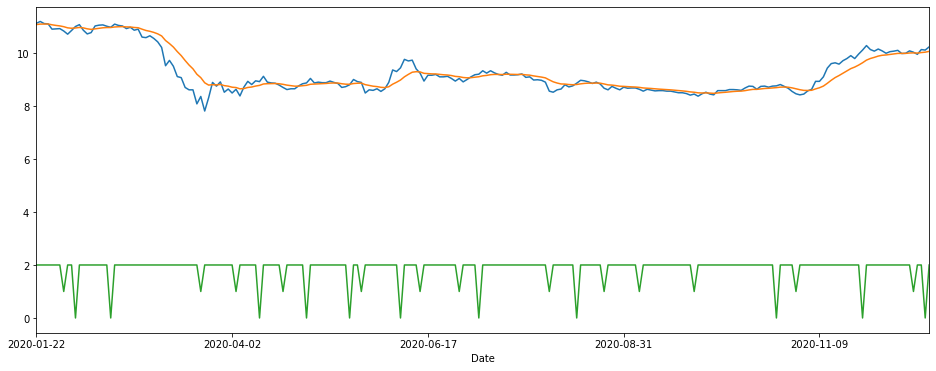

In [117]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

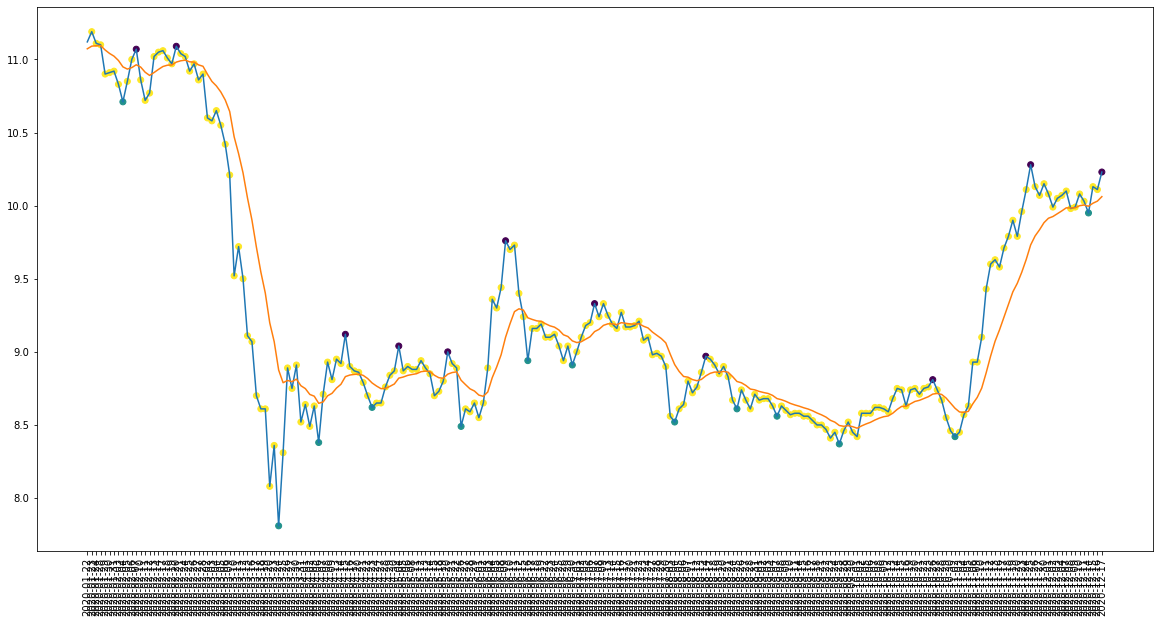

In [118]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [119]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
# price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [121]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [122]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [123]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 2ms/step - loss: 0.1280 - accuracy: 0.7256 - mean_squared_error: 2.6034 - weighted_accuracy: 0.7256 - weighted_mean_squared_error: 2.6034
Test loss: 0.12798605859279633
Test accuracy: 0.7255814075469971


In [124]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 167, 0: 25, 1: 23})

In [125]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [126]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [127]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2020-02-12        11.02  10.890637 -80.357049  13333200.0     2.0   
2020-02-13        11.05  10.910539 -32.075322  21593100.0     2.0   
2020-02-14        11.06  10.931995 -15.217324  25962500.0     2.0   
2020-02-17        11.01  10.951688 -13.043361  29610200.0     2.0   
2020-02-18        10.97  10.960659 -23.912967  27996300.0     2.0   

            predictions  actual  
Date                             
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-17            0       2  
2020-02-18            2       2

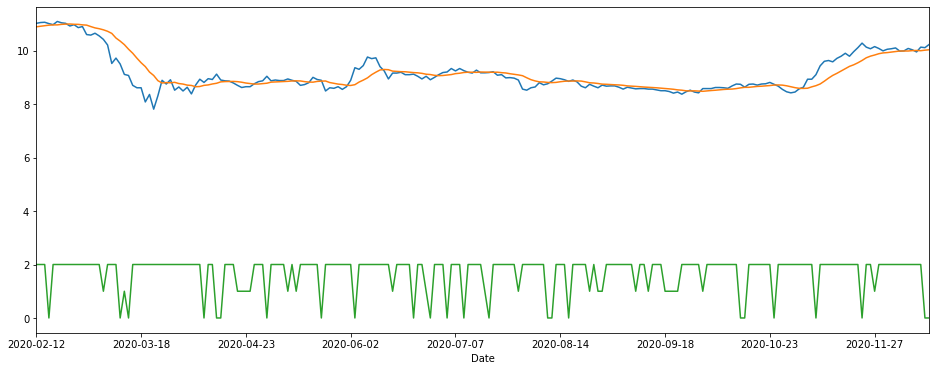

In [128]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

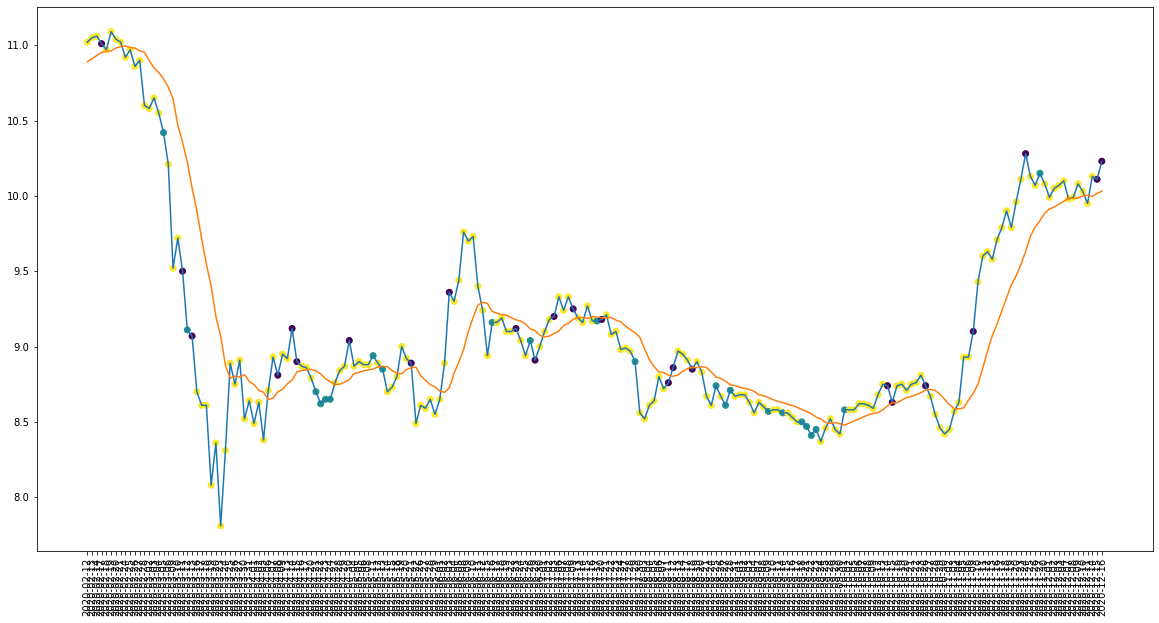

In [129]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

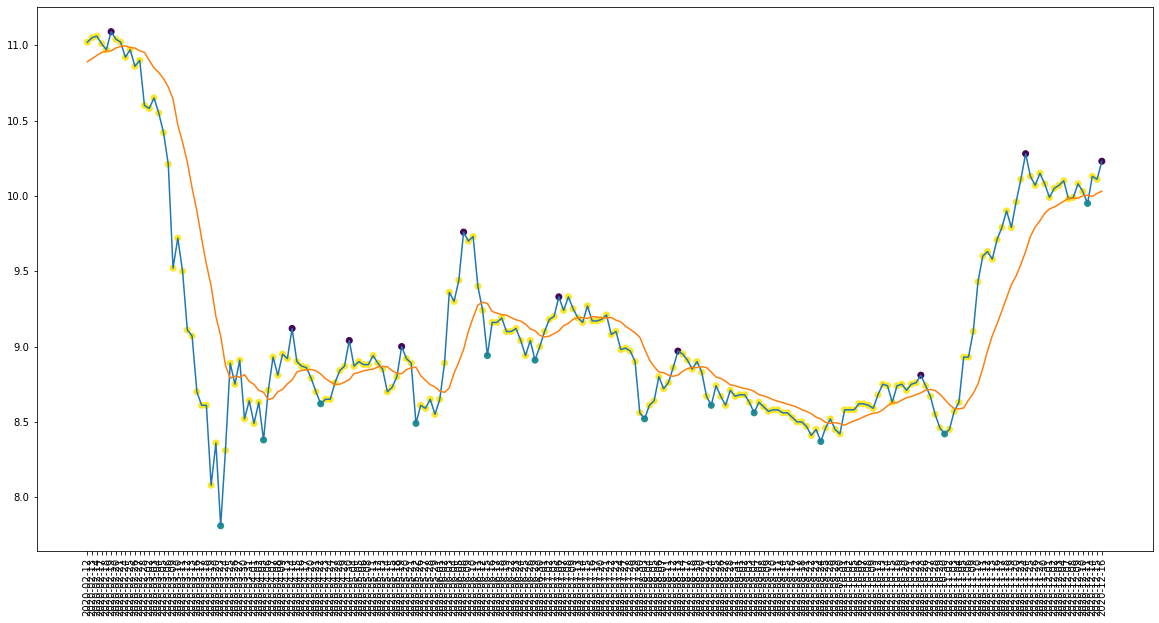

In [130]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [131]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 22
actual holds but predicted sell: 20
actual predicted holds: 151
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 40.0%
Percentage holds correct: 78.23834196891191%
actual buys: 12
actual sells: 10
actual holds: 193


In [132]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 56.52173913043478%
Percentage sells correct: 62.5%
Percentage holds correct: 86.82634730538922%


In [133]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.420000076293944
Shares owned at the moment: 957
Cash capital at the moment: $0.6370917859094334


Stop Loss Activated!

Share price: $9.520000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9086.223268661024


Share price: $9.109999656677246
Shares owned at the moment: 994
Cash capital at the moment: $5.981425862313699


Stop Loss Activated!

Share price: $8.699999809265138
Shares owned at the moment: 0
Cash capital at the moment: $8629.999786793234


Share price: $8.699999809265138
Shares owned at the moment: 989
Cash capital at the moment: $2.0381509487633593


Price increase from previously bought: 7.291154633741637%
Share price: $9.359999656677246
Shares owned at the moment: 0
Cash capital at the moment: $9233.620952336312


Share price: $9.15999984741211
Shares owned at the moment: 1005
Cash capital at the moment: $2.5051561088566814


Stop Loss Activated!

Share price: $8.899999618530273
Shares owned at the moment: 0
Cash capital at the momen

In [134]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


In [135]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys        correct_sells       correct_holds  \
0       0.614679  44.44444444444444%  33.333333333333336%               63.5%   
1       0.632558               62.5%  33.333333333333336%  64.64646464646465%   
2       0.701835               25.0%  33.333333333333336%   73.6318407960199%   
3       0.725581  8.333333333333334%                40.0%  78.23834196891191%   

      correct_low_buys  correct_high_sells   correct_mid_holds  \
0   52.63157894736842%  47.61904761904762%  81.02189781021897%   
1  61.111111111111114%  66.66666666666667%  86.76470588235294%   
2   71.42857142857143%  59.45945945945946%  85.53459119496856%   
3   56.52173913043478%               62.5%  86.82634730538922%   

          Profit gained     buy_n_hold profit  
0   -5.897446748158945%    -7.30802773938658%  
1  -16.343050759745328%  -48.998182398364555%  
2  -0.6691757968068305%   -5.545324129943856%  
3  -11.902462233216756%   -7.669883276367181%

## CNOOC Limited

In [136]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


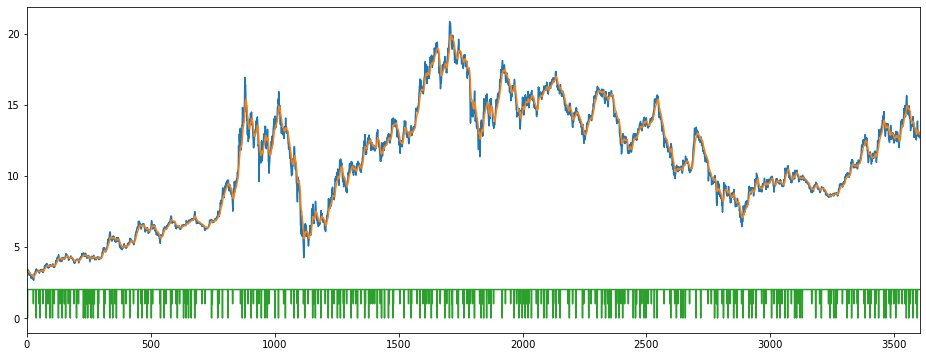

In [137]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [138]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0

In [139]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [140]:
willr_data = np.array(willr_data)
# price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [141]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [142]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(3590, 64, 64, 1)

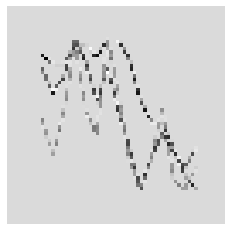

In [143]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [144]:
X = X/255

In [145]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [146]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [147]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [148]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [149]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.252525252525253, 1: 7.364102564102564, 2: 0.36679438058748404}
Epoch 1/200
23/23 [==============================] - 2s 108ms/step - loss: 0.2567 - accuracy: 0.4464 - mse: 1.6958 - weighted_accuracy: 0.3811 - weighted_mse: 1.7511 - val_loss: 0.2181 - val_accuracy: 0.0460 - val_mse: 1.1841 - val_weighted_accuracy: 0.0460 - val_weighted_mse: 1.1841
Epoch 2/200
23/23 [==============================] - 0s 15ms/step - loss: 0.2108 - accuracy: 0.3931 - mse: 1.2784 - weighted_accuracy: 0.3330 - weighted_mse: 1.2669 - val_loss: 0.1982 - val_accuracy: 0.0460 - val_mse: 1.0156 - val_weighted_accuracy: 0.0460 - val_weighted_mse: 1.0156
Epoch 3/200
23/23 [==============================] - 0s 15ms/step - loss: 0.2043 - accuracy: 0.2761 - mse: 1.1677 - weighted_accuracy: 0.3351 - weighted_mse: 1.1746 - val_loss: 0.2103 - val_accuracy: 0.0460 - val_mse: 1.0016 - val_weighted_accuracy: 0.0460 - val_weighted_mse: 1.0016
Epoch 4/200
23/23 [==============================] - 0s 16ms/step - loss: 0.20

23/23 [==============================] - 0s 14ms/step - loss: 0.1985 - accuracy: 0.2935 - mse: 1.1634 - weighted_accuracy: 0.3740 - weighted_mse: 1.1442 - val_loss: 0.1983 - val_accuracy: 0.0641 - val_mse: 0.9671 - val_weighted_accuracy: 0.0641 - val_weighted_mse: 0.9671
Epoch 29/200
23/23 [==============================] - 0s 15ms/step - loss: 0.1985 - accuracy: 0.2886 - mse: 1.2039 - weighted_accuracy: 0.3717 - weighted_mse: 1.2173 - val_loss: 0.2018 - val_accuracy: 0.0696 - val_mse: 0.9058 - val_weighted_accuracy: 0.0696 - val_weighted_mse: 0.9058
Epoch 30/200
23/23 [==============================] - 0s 14ms/step - loss: 0.1982 - accuracy: 0.2688 - mse: 1.1453 - weighted_accuracy: 0.3623 - weighted_mse: 1.1417 - val_loss: 0.2024 - val_accuracy: 0.0669 - val_mse: 0.9527 - val_weighted_accuracy: 0.0669 - val_weighted_mse: 0.9527
Epoch 31/200
23/23 [==============================] - 0s 15ms/step - loss: 0.1963 - accuracy: 0.2733 - mse: 1.1785 - weighted_accuracy: 0.3879 - weighted_mse:

Epoch 57/200
23/23 [==============================] - 0s 14ms/step - loss: 0.1866 - accuracy: 0.1797 - mse: 1.2403 - weighted_accuracy: 0.4359 - weighted_mse: 1.2259 - val_loss: 0.2002 - val_accuracy: 0.0738 - val_mse: 0.9531 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 0.9531
Epoch 58/200
23/23 [==============================] - 0s 15ms/step - loss: 0.1849 - accuracy: 0.1811 - mse: 1.2397 - weighted_accuracy: 0.4869 - weighted_mse: 1.2469 - val_loss: 0.1996 - val_accuracy: 0.0710 - val_mse: 0.9368 - val_weighted_accuracy: 0.0710 - val_weighted_mse: 0.9368
Epoch 59/200
23/23 [==============================] - 0s 15ms/step - loss: 0.1858 - accuracy: 0.1922 - mse: 1.2303 - weighted_accuracy: 0.4716 - weighted_mse: 1.2029 - val_loss: 0.1958 - val_accuracy: 0.0780 - val_mse: 1.1348 - val_weighted_accuracy: 0.0780 - val_weighted_mse: 1.1348
Epoch 60/200
23/23 [==============================] - 0s 14ms/step - loss: 0.1843 - accuracy: 0.1751 - mse: 1.2425 - weighted_accuracy: 0.5017 - 

Epoch 86/200
23/23 [==============================] - 0s 16ms/step - loss: 0.1694 - accuracy: 0.1556 - mse: 1.3541 - weighted_accuracy: 0.5353 - weighted_mse: 1.3047 - val_loss: 0.1967 - val_accuracy: 0.1309 - val_mse: 1.1969 - val_weighted_accuracy: 0.1309 - val_weighted_mse: 1.1969
Epoch 87/200
23/23 [==============================] - 0s 14ms/step - loss: 0.1715 - accuracy: 0.1546 - mse: 1.3338 - weighted_accuracy: 0.5299 - weighted_mse: 1.2901 - val_loss: 0.1973 - val_accuracy: 0.1393 - val_mse: 1.1576 - val_weighted_accuracy: 0.1393 - val_weighted_mse: 1.1576
Epoch 88/200
23/23 [==============================] - 0s 14ms/step - loss: 0.1708 - accuracy: 0.1654 - mse: 1.3326 - weighted_accuracy: 0.5386 - weighted_mse: 1.2915 - val_loss: 0.1970 - val_accuracy: 0.1337 - val_mse: 1.1704 - val_weighted_accuracy: 0.1337 - val_weighted_mse: 1.1704
Epoch 89/200
23/23 [==============================] - 0s 14ms/step - loss: 0.1679 - accuracy: 0.1598 - mse: 1.3889 - weighted_accuracy: 0.5369 - 

Epoch 115/200
23/23 [==============================] - 0s 15ms/step - loss: 0.1503 - accuracy: 0.2235 - mse: 1.4852 - weighted_accuracy: 0.6256 - weighted_mse: 1.4819 - val_loss: 0.1957 - val_accuracy: 0.2159 - val_mse: 1.3568 - val_weighted_accuracy: 0.2159 - val_weighted_mse: 1.3568
Epoch 116/200
23/23 [==============================] - 0s 15ms/step - loss: 0.1507 - accuracy: 0.2173 - mse: 1.4839 - weighted_accuracy: 0.6040 - weighted_mse: 1.4952 - val_loss: 0.1953 - val_accuracy: 0.2103 - val_mse: 1.3712 - val_weighted_accuracy: 0.2103 - val_weighted_mse: 1.3712
Epoch 117/200
23/23 [==============================] - 0s 17ms/step - loss: 0.1533 - accuracy: 0.2194 - mse: 1.5158 - weighted_accuracy: 0.6169 - weighted_mse: 1.5284 - val_loss: 0.1929 - val_accuracy: 0.1852 - val_mse: 1.3228 - val_weighted_accuracy: 0.1852 - val_weighted_mse: 1.3228
Epoch 118/200
23/23 [==============================] - 0s 16ms/step - loss: 0.1539 - accuracy: 0.2246 - mse: 1.4692 - weighted_accuracy: 0.601

Epoch 144/200
23/23 [==============================] - 0s 15ms/step - loss: 0.1424 - accuracy: 0.2862 - mse: 1.6656 - weighted_accuracy: 0.6608 - weighted_mse: 1.7440 - val_loss: 0.1939 - val_accuracy: 0.2660 - val_mse: 1.5074 - val_weighted_accuracy: 0.2660 - val_weighted_mse: 1.5074
Epoch 145/200
23/23 [==============================] - 0s 15ms/step - loss: 0.1457 - accuracy: 0.2782 - mse: 1.6552 - weighted_accuracy: 0.6409 - weighted_mse: 1.6885 - val_loss: 0.1934 - val_accuracy: 0.2618 - val_mse: 1.5124 - val_weighted_accuracy: 0.2618 - val_weighted_mse: 1.5124
Epoch 146/200
23/23 [==============================] - 0s 14ms/step - loss: 0.1403 - accuracy: 0.2796 - mse: 1.7299 - weighted_accuracy: 0.6533 - weighted_mse: 1.8484 - val_loss: 0.1904 - val_accuracy: 0.2799 - val_mse: 1.5306 - val_weighted_accuracy: 0.2799 - val_weighted_mse: 1.5306
Epoch 147/200
23/23 [==============================] - 0s 14ms/step - loss: 0.1393 - accuracy: 0.2855 - mse: 1.7044 - weighted_accuracy: 0.665

23/23 [==============================] - 0s 10ms/step - loss: 0.1328 - accuracy: 0.3673 - mse: 1.8472 - weighted_accuracy: 0.7002 - weighted_mse: 2.0860 - val_loss: 0.1812 - val_accuracy: 0.3774 - val_mse: 1.6213 - val_weighted_accuracy: 0.3774 - val_weighted_mse: 1.6213
Epoch 173/200
23/23 [==============================] - 0s 10ms/step - loss: 0.1313 - accuracy: 0.3792 - mse: 1.9100 - weighted_accuracy: 0.7191 - weighted_mse: 2.1178 - val_loss: 0.1787 - val_accuracy: 0.4011 - val_mse: 1.6537 - val_weighted_accuracy: 0.4011 - val_weighted_mse: 1.6537
Epoch 174/200
23/23 [==============================] - 0s 10ms/step - loss: 0.1357 - accuracy: 0.3753 - mse: 1.8542 - weighted_accuracy: 0.6911 - weighted_mse: 2.0312 - val_loss: 0.1824 - val_accuracy: 0.3719 - val_mse: 1.6530 - val_weighted_accuracy: 0.3719 - val_weighted_mse: 1.6530
Epoch 175/200
23/23 [==============================] - 0s 10ms/step - loss: 0.1286 - accuracy: 0.3955 - mse: 1.9522 - weighted_accuracy: 0.7081 - weighted_m

In [150]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.16110268235206604
Test accuracy: 0.5710306167602539


In [151]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.97403675 -1.2258419  -0.43972713]
 [-0.07998693 -1.9432684  -0.7093693 ]
 [-1.9600914  -0.6839889  -0.3692765 ]
 ...
 [-2.5984476   0.03586505 -0.7664542 ]
 [-1.1119186  -0.8266456  -0.48835373]
 [-1.6342354  -0.90930855 -0.2783079 ]]


Counter({2: 408, 0: 190, 1: 120})

In [152]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 653, 0: 33, 1: 32})

In [153]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 718
actual predicted buys: 17
actual buys but predicted sell: 1
actual buys but predicted hold: 14
actual sells but predicted buy: 0
actual predicted sells: 16
actual sells but predicted hold: 17
actual holds but predicted buy: 103
actual holds but predicted sell: 173
actual predicted holds: 377
Percentage buys correct: 53.125%
Percentage sells correct: 48.484848484848484%
Percentage holds correct: 57.733537519142416%
actual buys: 32
actual sells: 33
actual holds: 653


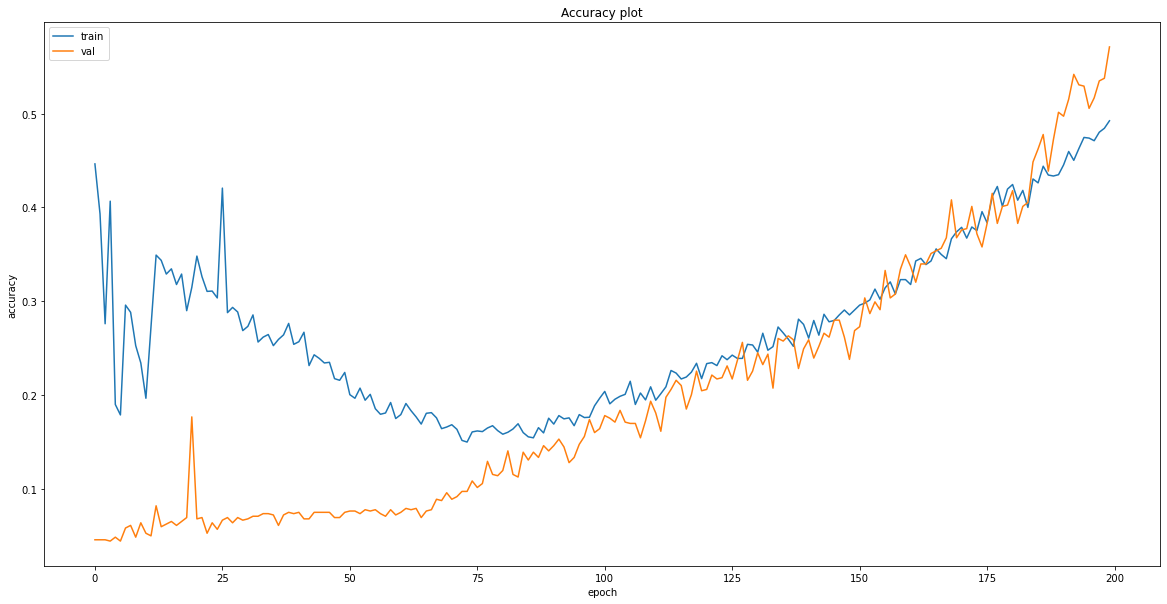

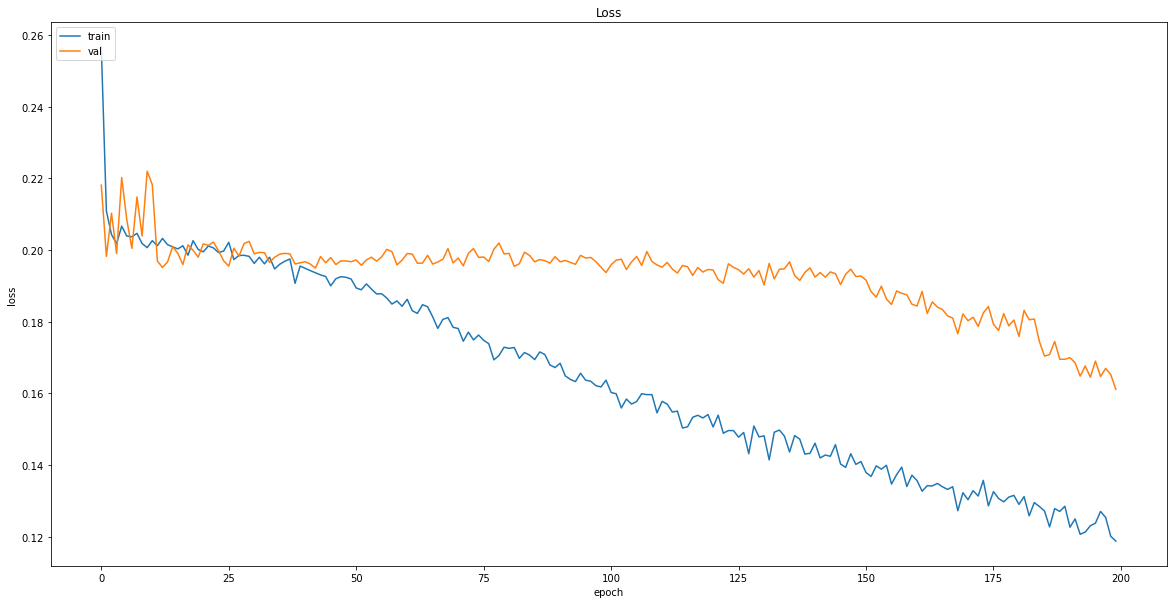

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [155]:
# Save model
model.save("models/{}".format('cnooc_image_cnn_buy_hold_sell_no_close.model'))

INFO:tensorflow:Assets written to: models/cnooc_image_cnn_buy_hold_sell_no_close.model\assets


### Test Performance

#### Non-Recession

In [156]:
logger = []

In [157]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22        13.12  12.552209  -3.030323  489168111.0     2.0
2019-01-23        12.94  12.611869 -13.043517  449876554.0     2.0
2019-01-24        12.62  12.613120 -33.333352  395082483.0     2.0
2019-01-25        12.80  12.641871 -37.254896  441807090.0     2.0
2019-01-28        13.06  12.706198 -11.764689  494043477.0     2.0


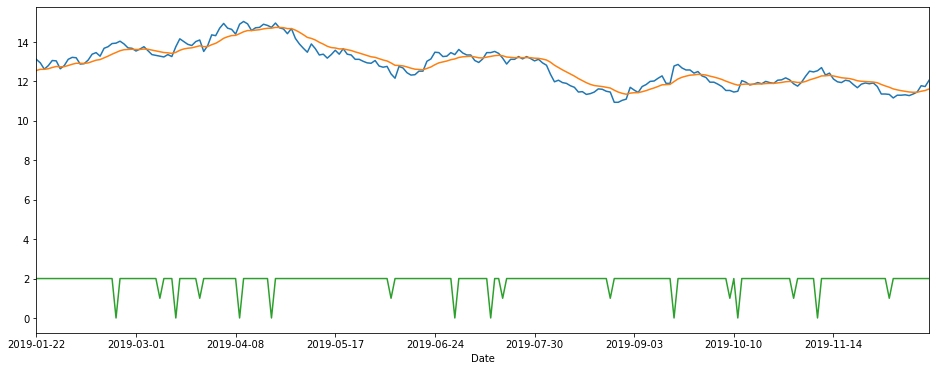

In [158]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [159]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
# price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [160]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [161]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [162]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [163]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 7ms/step - loss: 0.1614 - accuracy: 0.5735 - mean_squared_error: 1.8456 - weighted_accuracy: 0.5735 - weighted_mean_squared_error: 1.8456
Test loss: 0.16135115921497345
Test accuracy: 0.5734597444534302


In [164]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 45, 2: 123, 1: 43})

In [165]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [166]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)

In [167]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2019-02-14        13.46  13.005887  -9.090899  594167146.0     2.0   
2019-02-15        13.28  13.075751  -2.222168  636062191.0     2.0   
2019-02-18        13.68  13.107174 -22.222210  601994876.0     2.0   
2019-02-19        13.76  13.195301 -15.384598  654106730.0     2.0   
2019-02-20        13.92  13.282178  -9.230759  687559434.0     2.0   

            predictions  actual  
Date                             
2019-02-14            0       2  
2019-02-15            0       2  
2019-02-18            0       2  
2019-02-19            0       2  
2019-02-20            0       2

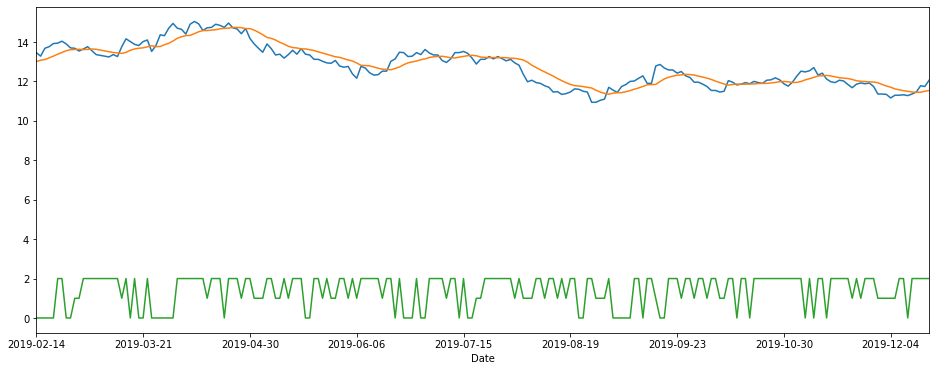

In [168]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

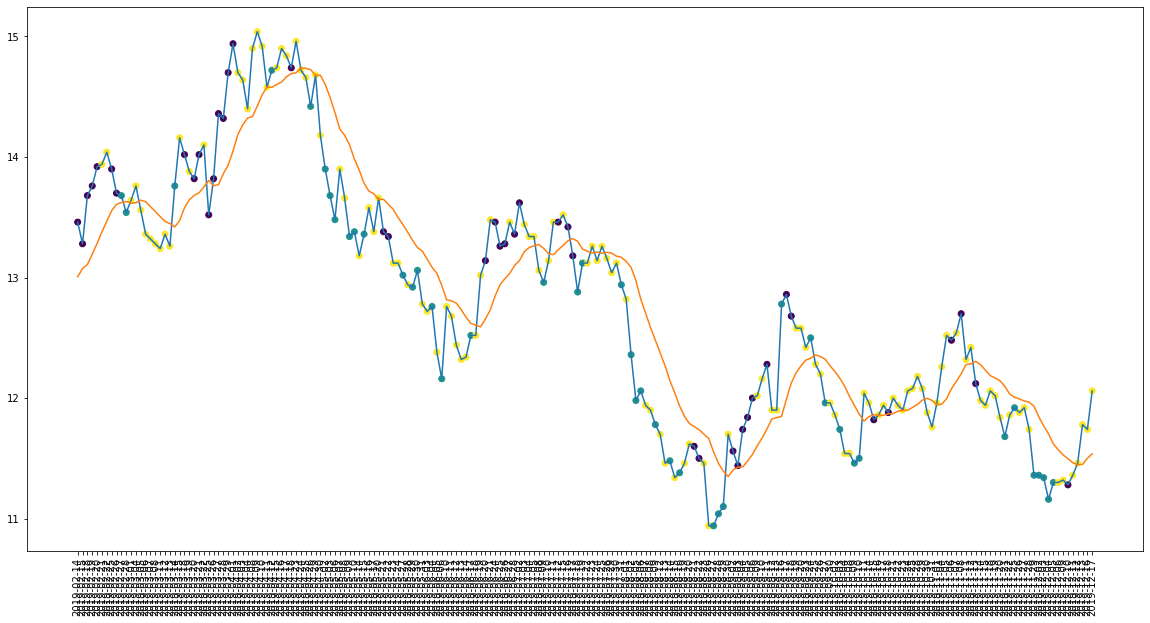

In [169]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

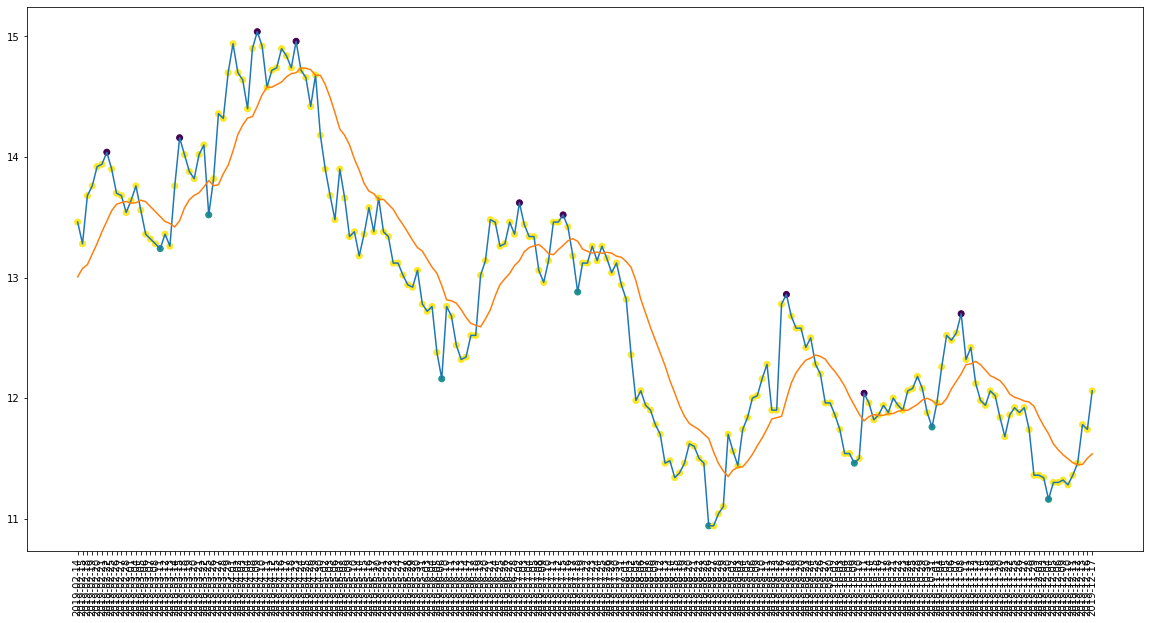

In [170]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [171]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 211
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 39
actual holds but predicted sell: 41
actual predicted holds: 114
Percentage buys correct: 50.0%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 58.76288659793814%
actual buys: 8
actual sells: 9
actual holds: 194


In [172]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 67.44186046511628%
Percentage sells correct: 47.72727272727273%
Percentage holds correct: 80.48780487804878%


In [173]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.68000030517578
Shares owned at the moment: 728
Cash capital at the moment: $13.572417221070282


Stop Loss Activated!

Share price: $13.279999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9654.825663358692


Share price: $13.760000228881836
Shares owned at the moment: 699
Cash capital at the moment: $10.135342930319894


Price increase from previously bought: 6.538411553891654%
Share price: $14.699999809265135
Shares owned at the moment: 0
Cash capital at the moment: $10257.178134973288


Share price: $14.720000267028807
Shares owned at the moment: 694
Cash capital at the moment: $13.40482914567292


Stop Loss Activated!

Share price: $14.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9827.262510355235


Share price: $13.899999618530273
Shares owned at the moment: 705
Cash capital at the moment: $0.8141550309665035


Stop Loss Activated!

Share price: $13.479999542236328
Shares owned at the moment: 0
Cash capital at the

In [174]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


In [175]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys        correct_sells       correct_holds  \
0       0.614679  44.44444444444444%  33.333333333333336%               63.5%   
1       0.632558               62.5%  33.333333333333336%  64.64646464646465%   
2       0.701835               25.0%  33.333333333333336%   73.6318407960199%   
3       0.725581  8.333333333333334%                40.0%  78.23834196891191%   
4       0.573460               50.0%  33.333333333333336%  58.76288659793814%   

      correct_low_buys  correct_high_sells   correct_mid_holds  \
0   52.63157894736842%  47.61904761904762%  81.02189781021897%   
1  61.111111111111114%  66.66666666666667%  86.76470588235294%   
2   71.42857142857143%  59.45945945945946%  85.53459119496856%   
3   56.52173913043478%               62.5%  86.82634730538922%   
4   67.44186046511628%  47.72727272727273%  80.48780487804878%   

          Profit gained     buy_n_hold profit  
0   -5.897446748158945%    -7.30802773938658%  
1  -16.343050759745328%  -48.998182398364555%  
2  -0.6691757968068305%   -5.545324129943856%  
3  -11.902462233216756%   -7.669883276367181%  
4   -21.76057925191646%  -10.879329186439518%

### Recession

In [176]:
logger = []

In [177]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-01-22        13.00  13.393678 -83.870980  104646165.0     2.0
2020-01-23        13.34  13.385420 -57.377021  145802714.0     2.0
2020-01-24        13.00  13.326125 -85.245880   96260120.0     2.0
2020-01-29        13.04  13.282106 -80.645176  122828433.0     2.0
2020-01-30        12.46  13.155628 -90.804605   53693706.0     2.0


In [178]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
# price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [179]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [180]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [181]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [182]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 7ms/step - loss: 0.1561 - accuracy: 0.5962 - mean_squared_error: 1.7733 - weighted_accuracy: 0.5962 - weighted_mean_squared_error: 1.7733
Test loss: 0.15613201260566711
Test accuracy: 0.5962441563606262


In [183]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 42, 2: 130, 1: 41})

In [184]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [185]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)

In [186]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2020-02-13        12.34  12.385912 -50.526328  113135355.0     2.0   
2020-02-14        12.34  12.378849 -50.588221   60757697.0     2.0   
2020-02-17        12.26  12.372872 -46.153851   60757697.0     2.0   
2020-02-18        12.00  12.355507 -38.709648    5146960.0     2.0   
2020-02-19        12.08  12.300814 -59.677412  -52626865.0     2.0   

            predictions  actual  
Date                             
2020-02-13            0       2  
2020-02-14            0       2  
2020-02-17            2       2  
2020-02-18            2       2  
2020-02-19            2       2

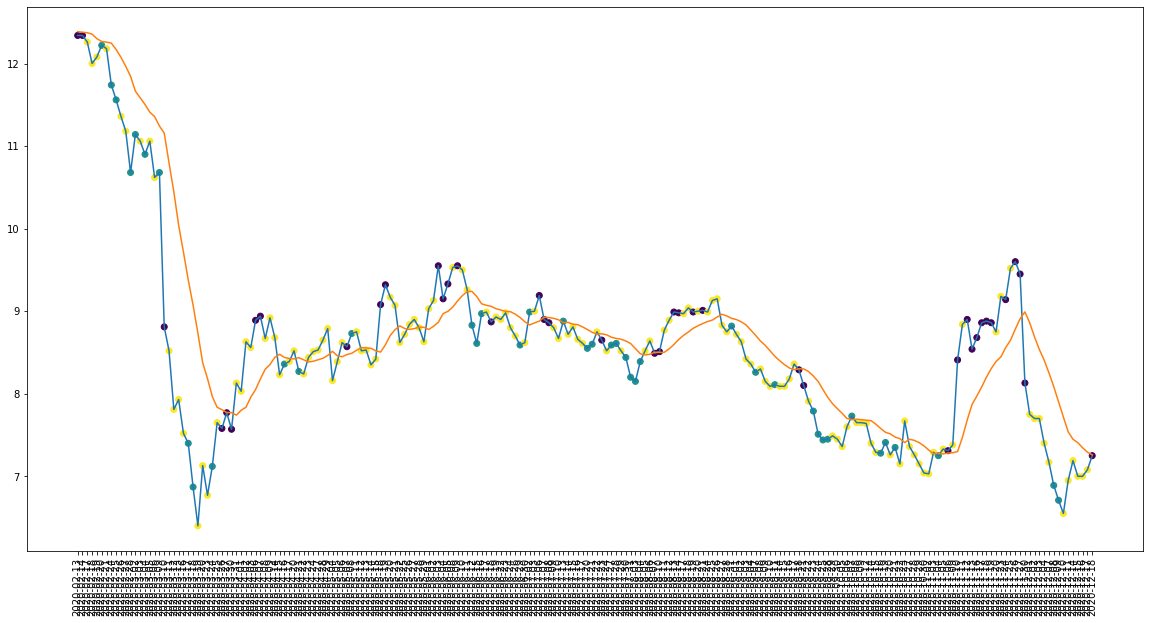

In [187]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

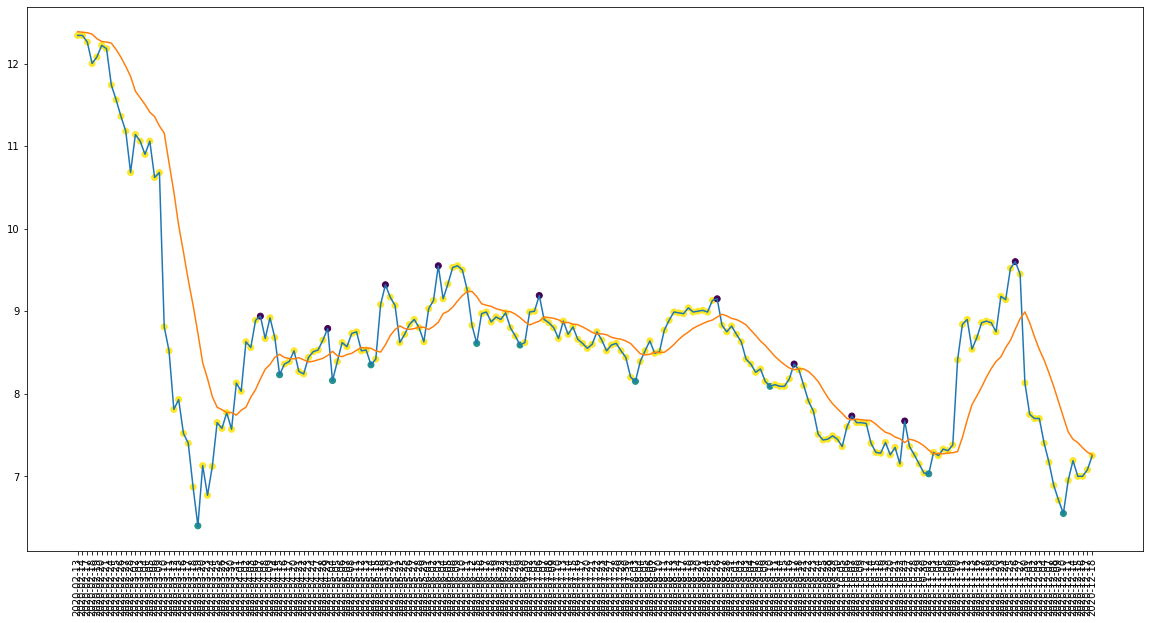

In [188]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [189]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 213
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 37
actual holds but predicted sell: 37
actual predicted holds: 119
Percentage buys correct: 30.0%
Percentage sells correct: 50.0%
Percentage holds correct: 61.6580310880829%
actual buys: 10
actual sells: 10
actual holds: 193


In [190]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 53.65853658536585%
Percentage sells correct: 53.65853658536585%
Percentage holds correct: 83.07692307692308%


In [191]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $12.220000267028807
Shares owned at the moment: 816
Cash capital at the moment: $1.058101505281229


Stop Loss Activated!

Share price: $11.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9554.553355251313


Share price: $11.739999771118164
Shares owned at the moment: 811
Cash capital at the moment: $7.230406384946036


Stop Loss Activated!

Share price: $11.359999656677244
Shares owned at the moment: 0
Cash capital at the moment: $9194.854488715886


Share price: $10.68000030517578
Shares owned at the moment: 858
Cash capital at the moment: $6.214766155004327


Stop Loss Activated!

Share price: $8.8100004196167
Shares owned at the moment: 0
Cash capital at the moment: $7544.407930196046


Share price: $7.400000095367432
Shares owned at the moment: 1016
Cash capital at the moment: $5.332233036278922


Stop Loss Activated!

Share price: $6.869999885559082
Shares owned at the moment: 0
Cash capital at the moment: $6966.057337084054


Share price: 

In [192]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


In [193]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys        correct_sells       correct_holds  \
0       0.614679  44.44444444444444%  33.333333333333336%               63.5%   
1       0.632558               62.5%  33.333333333333336%  64.64646464646465%   
2       0.701835               25.0%  33.333333333333336%   73.6318407960199%   
3       0.725581  8.333333333333334%                40.0%  78.23834196891191%   
4       0.573460               50.0%  33.333333333333336%  58.76288659793814%   
5       0.596244               30.0%                50.0%   61.6580310880829%   

      correct_low_buys  correct_high_sells   correct_mid_holds  \
0   52.63157894736842%  47.61904761904762%  81.02189781021897%   
1  61.111111111111114%  66.66666666666667%  86.76470588235294%   
2   71.42857142857143%  59.45945945945946%  85.53459119496856%   
3   56.52173913043478%               62.5%  86.82634730538922%   
4   67.44186046511628%  47.72727272727273%  80.48780487804878%   
5   53.65853658536585%  53.65853658536585%  83.07692307692308%   

          Profit gained     buy_n_hold profit  
0   -5.897446748158945%    -7.30802773938658%  
1  -16.343050759745328%  -48.998182398364555%  
2  -0.6691757968068305%   -5.545324129943856%  
3  -11.902462233216756%   -7.669883276367181%  
4   -21.76057925191646%  -10.879329186439518%  
5    -35.1077277616251%   -41.56249103630067%

## JP Morgan

In [194]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


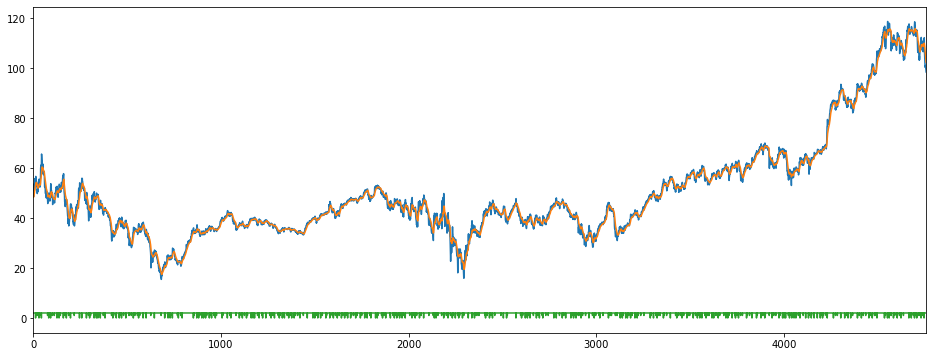

In [195]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [196]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0

In [197]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [198]:
willr_data = np.array(willr_data)
# price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [199]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [200]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

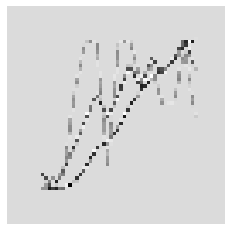

In [201]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [202]:
X = X/255

In [203]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [204]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [205]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [206]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [207]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.715447154471545, 1: 7.3996101364522415, 2: 0.36559761148030434}
Epoch 1/200
30/30 [==============================] - 2s 79ms/step - loss: 0.2475 - accuracy: 0.4391 - mse: 1.6334 - weighted_accuracy: 0.3219 - weighted_mse: 1.7652 - val_loss: 0.2027 - val_accuracy: 0.0432 - val_mse: 1.0690 - val_weighted_accuracy: 0.0432 - val_weighted_mse: 1.0690
Epoch 2/200
30/30 [==============================] - 0s 14ms/step - loss: 0.2040 - accuracy: 0.3224 - mse: 1.2033 - weighted_accuracy: 0.3301 - weighted_mse: 1.1947 - val_loss: 0.2104 - val_accuracy: 0.0432 - val_mse: 1.0153 - val_weighted_accuracy: 0.0432 - val_weighted_mse: 1.0153
Epoch 3/200
30/30 [==============================] - 0s 15ms/step - loss: 0.2029 - accuracy: 0.2787 - mse: 1.1856 - weighted_accuracy: 0.3461 - weighted_mse: 1.1735 - val_loss: 0.1938 - val_accuracy: 0.8641 - val_mse: 0.8140 - val_weighted_accuracy: 0.8641 - val_weighted_mse: 0.8140
Epoch 4/200
30/30 [==============================] - 0s 14ms/step - loss: 0.20

30/30 [==============================] - 0s 15ms/step - loss: 0.1943 - accuracy: 0.1886 - mse: 1.2515 - weighted_accuracy: 0.4285 - weighted_mse: 1.2103 - val_loss: 0.2036 - val_accuracy: 0.0695 - val_mse: 1.0032 - val_weighted_accuracy: 0.0695 - val_weighted_mse: 1.0032
Epoch 29/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1914 - accuracy: 0.2215 - mse: 1.1980 - weighted_accuracy: 0.4497 - weighted_mse: 1.1910 - val_loss: 0.2044 - val_accuracy: 0.0653 - val_mse: 1.0758 - val_weighted_accuracy: 0.0653 - val_weighted_mse: 1.0758
Epoch 30/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1922 - accuracy: 0.2089 - mse: 1.2190 - weighted_accuracy: 0.4321 - weighted_mse: 1.2112 - val_loss: 0.2050 - val_accuracy: 0.0706 - val_mse: 0.9801 - val_weighted_accuracy: 0.0706 - val_weighted_mse: 0.9801
Epoch 31/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1908 - accuracy: 0.1907 - mse: 1.2374 - weighted_accuracy: 0.4444 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1764 - accuracy: 0.1797 - mse: 1.3327 - weighted_accuracy: 0.5140 - weighted_mse: 1.2688 - val_loss: 0.1891 - val_accuracy: 0.1749 - val_mse: 1.3167 - val_weighted_accuracy: 0.1749 - val_weighted_mse: 1.3167
Epoch 58/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1711 - accuracy: 0.1691 - mse: 1.3391 - weighted_accuracy: 0.5482 - weighted_mse: 1.3320 - val_loss: 0.2009 - val_accuracy: 0.0738 - val_mse: 1.1890 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 1.1890
Epoch 59/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1764 - accuracy: 0.1560 - mse: 1.3840 - weighted_accuracy: 0.5350 - weighted_mse: 1.2969 - val_loss: 0.2000 - val_accuracy: 0.0811 - val_mse: 1.1327 - val_weighted_accuracy: 0.0811 - val_weighted_mse: 1.1327
Epoch 60/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1741 - accuracy: 0.1694 - mse: 1.3970 - weighted_accuracy: 0.5359 - 

Epoch 86/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1536 - accuracy: 0.2468 - mse: 1.5185 - weighted_accuracy: 0.6099 - weighted_mse: 1.5024 - val_loss: 0.1974 - val_accuracy: 0.1939 - val_mse: 1.3612 - val_weighted_accuracy: 0.1939 - val_weighted_mse: 1.3612
Epoch 87/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1532 - accuracy: 0.2447 - mse: 1.5578 - weighted_accuracy: 0.6171 - weighted_mse: 1.5117 - val_loss: 0.1922 - val_accuracy: 0.2107 - val_mse: 1.3156 - val_weighted_accuracy: 0.2107 - val_weighted_mse: 1.3156
Epoch 88/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1556 - accuracy: 0.2487 - mse: 1.5021 - weighted_accuracy: 0.6015 - weighted_mse: 1.4669 - val_loss: 0.1905 - val_accuracy: 0.2086 - val_mse: 1.3632 - val_weighted_accuracy: 0.2086 - val_weighted_mse: 1.3632
Epoch 89/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1529 - accuracy: 0.2526 - mse: 1.5098 - weighted_accuracy: 0.6086 - 

Epoch 115/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1364 - accuracy: 0.3659 - mse: 1.7495 - weighted_accuracy: 0.6859 - weighted_mse: 1.8717 - val_loss: 0.1828 - val_accuracy: 0.3404 - val_mse: 1.6000 - val_weighted_accuracy: 0.3404 - val_weighted_mse: 1.6000
Epoch 116/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1372 - accuracy: 0.3788 - mse: 1.7048 - weighted_accuracy: 0.6834 - weighted_mse: 1.7877 - val_loss: 0.1885 - val_accuracy: 0.3372 - val_mse: 1.6671 - val_weighted_accuracy: 0.3372 - val_weighted_mse: 1.6671
Epoch 117/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1354 - accuracy: 0.3788 - mse: 1.7436 - weighted_accuracy: 0.6965 - weighted_mse: 1.8679 - val_loss: 0.1864 - val_accuracy: 0.3277 - val_mse: 1.5348 - val_weighted_accuracy: 0.3277 - val_weighted_mse: 1.5348
Epoch 118/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1338 - accuracy: 0.3599 - mse: 1.7594 - weighted_accuracy: 0.682

Epoch 144/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1189 - accuracy: 0.5169 - mse: 2.0427 - weighted_accuracy: 0.7393 - weighted_mse: 2.3907 - val_loss: 0.1655 - val_accuracy: 0.5279 - val_mse: 1.6105 - val_weighted_accuracy: 0.5279 - val_weighted_mse: 1.6105
Epoch 145/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1205 - accuracy: 0.5192 - mse: 1.9525 - weighted_accuracy: 0.7484 - weighted_mse: 2.2418 - val_loss: 0.1792 - val_accuracy: 0.4320 - val_mse: 1.6863 - val_weighted_accuracy: 0.4320 - val_weighted_mse: 1.6863
Epoch 146/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1185 - accuracy: 0.5340 - mse: 2.0142 - weighted_accuracy: 0.7570 - weighted_mse: 2.3830 - val_loss: 0.1662 - val_accuracy: 0.5269 - val_mse: 1.7475 - val_weighted_accuracy: 0.5269 - val_weighted_mse: 1.7475
Epoch 147/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1147 - accuracy: 0.5382 - mse: 2.0220 - weighted_accuracy: 0.777

Epoch 173/200
30/30 [==============================] - 0s 14ms/step - loss: 0.0981 - accuracy: 0.6596 - mse: 2.5416 - weighted_accuracy: 0.8165 - weighted_mse: 3.4535 - val_loss: 0.1440 - val_accuracy: 0.6828 - val_mse: 1.9932 - val_weighted_accuracy: 0.6828 - val_weighted_mse: 1.9932
Epoch 174/200
30/30 [==============================] - 0s 14ms/step - loss: 0.0967 - accuracy: 0.6636 - mse: 2.4913 - weighted_accuracy: 0.8257 - weighted_mse: 3.4155 - val_loss: 0.1374 - val_accuracy: 0.7071 - val_mse: 2.2762 - val_weighted_accuracy: 0.7071 - val_weighted_mse: 2.2762
Epoch 175/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1012 - accuracy: 0.6681 - mse: 2.5362 - weighted_accuracy: 0.8124 - weighted_mse: 3.3225 - val_loss: 0.1439 - val_accuracy: 0.6754 - val_mse: 2.1260 - val_weighted_accuracy: 0.6754 - val_weighted_mse: 2.1260
Epoch 176/200
30/30 [==============================] - 0s 15ms/step - loss: 0.0899 - accuracy: 0.6760 - mse: 2.6604 - weighted_accuracy: 0.852

In [208]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.13030582666397095
Test accuracy: 0.7439410090446472


In [209]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.5334822  -1.3040881   0.15262169]
 [-0.7726192  -2.3625867  -0.11438099]
 [-0.03213704 -2.7814693  -0.60119617]
 ...
 [-2.5415435  -0.74251217 -0.09940168]
 [-1.1975493  -1.5258985  -0.02207795]
 [-0.06985346 -2.7007234  -0.63539994]]


Counter({2: 763, 0: 142, 1: 44})

In [210]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 865, 0: 41, 1: 43})

In [211]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 39
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 31
actual holds but predicted buy: 41
actual holds but predicted sell: 131
actual predicted holds: 693
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 24.390243902439025%
Percentage holds correct: 80.11560693641619%
actual buys: 43
actual sells: 41
actual holds: 865


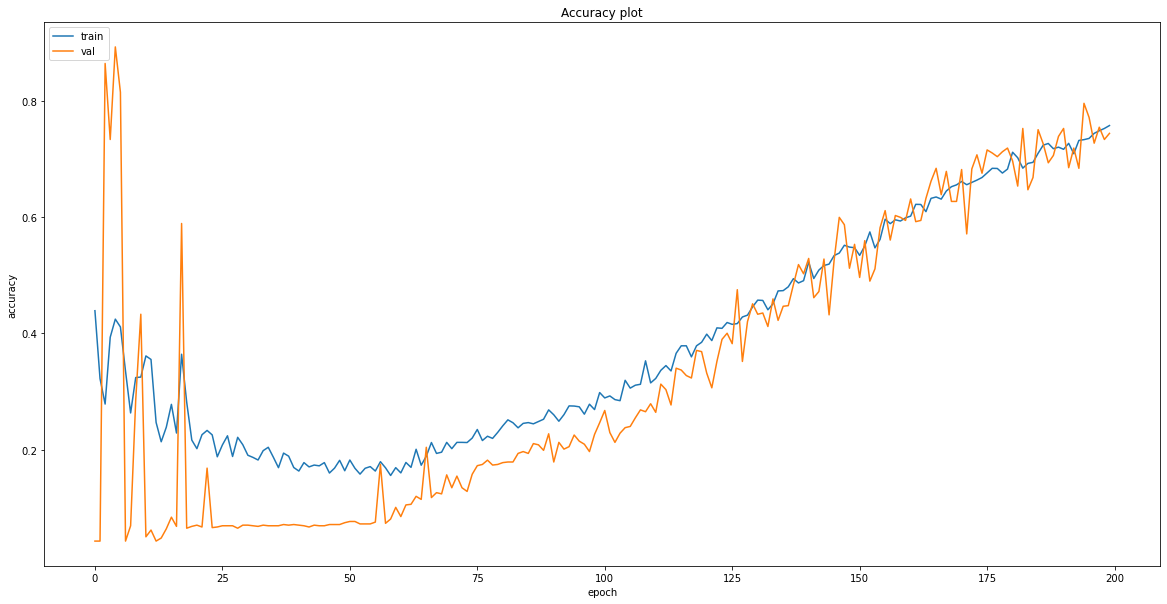

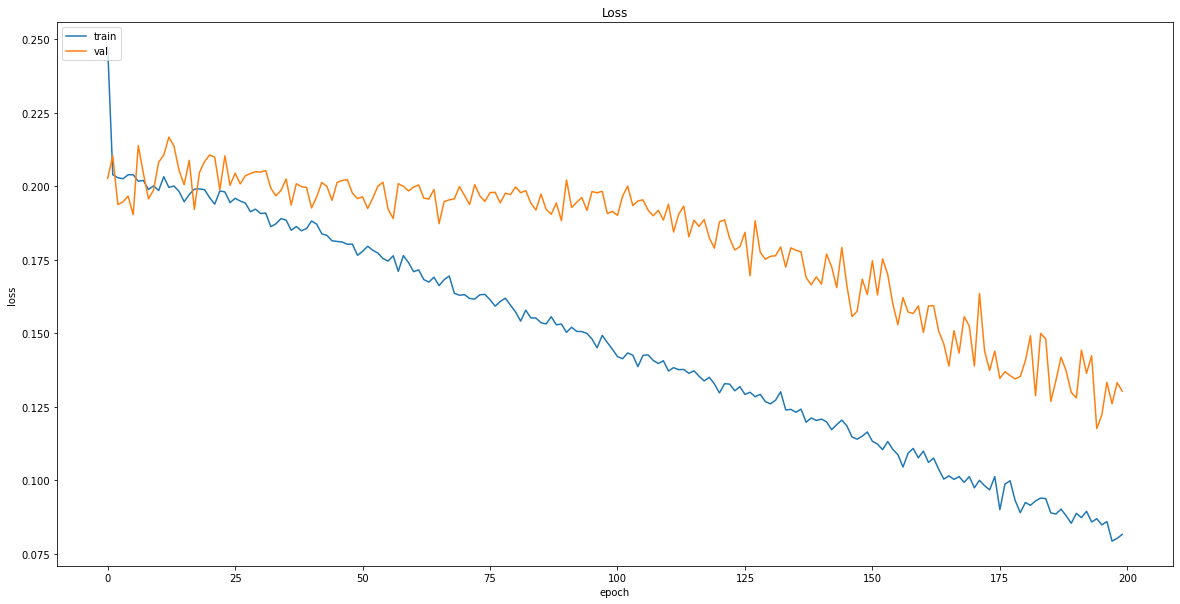

In [212]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [213]:
# Save model
model.save("models/{}".format('jpm_image_cnn_buy_hold_sell_no_close.model'))

INFO:tensorflow:Assets written to: models/jpm_image_cnn_buy_hold_sell_no_close.model\assets


### Test Performance

### non-recession

In [214]:
logger = []

In [215]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   104.589996  101.198442  -3.459880  84335200.0     2.0
2019-01-23   102.940002  101.466374 -21.874992  67251500.0     2.0
2019-01-24   102.680000  101.653086 -27.040213  55104800.0     2.0
2019-01-25   102.739998  101.820303 -32.628441  66401600.0     2.0
2019-01-28   103.389999  102.061795 -23.968276  80771000.0     2.0


In [216]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
# price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [217]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [218]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [219]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [220]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1228 - accuracy: 0.7615 - mean_squared_error: 2.5381 - weighted_accuracy: 0.7615 - weighted_mean_squared_error: 2.5381
Test loss: 0.12277917563915253
Test accuracy: 0.7614678740501404


In [221]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 13, 2: 173, 0: 32})

In [222]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [223]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)

In [224]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2019-02-11   100.879997  102.975915 -74.903417  73097300.0     1.0   
2019-02-12   102.599998  102.653466 -84.169891  62118800.0     2.0   
2019-02-13   103.089996  102.645240 -50.965236  74971100.0     2.0   
2019-02-14   102.419998  102.713664 -41.505819  85725200.0     2.0   
2019-02-15   105.550003  102.668485 -54.440145  74206700.0     2.0   

            predictions  actual  
Date                             
2019-02-11            1       1  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            2       2

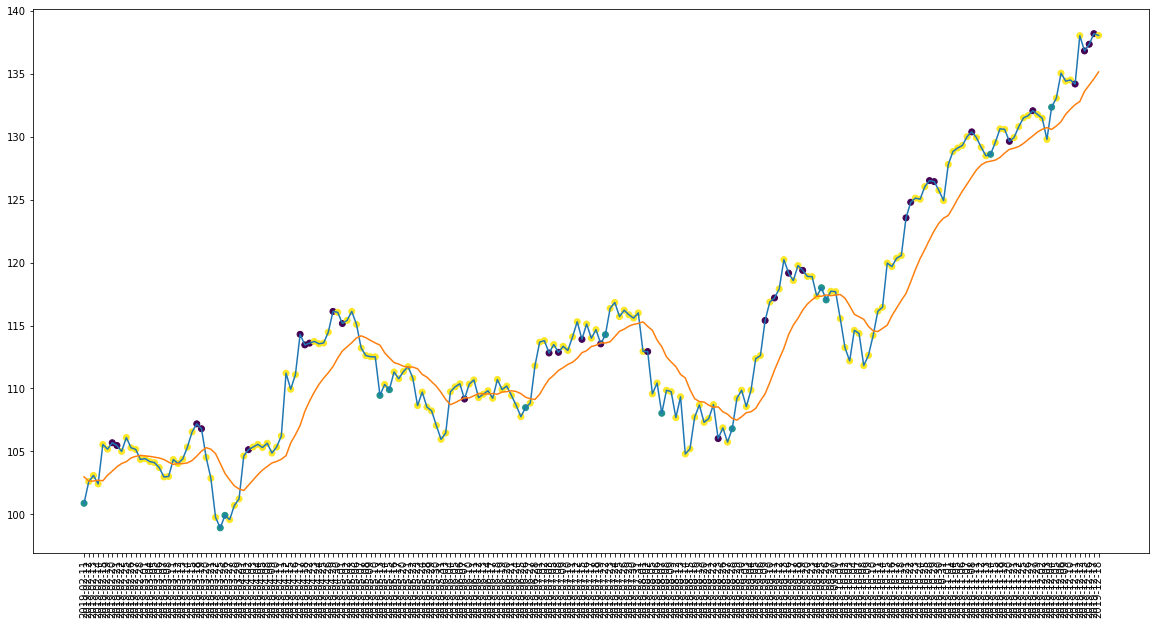

In [225]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

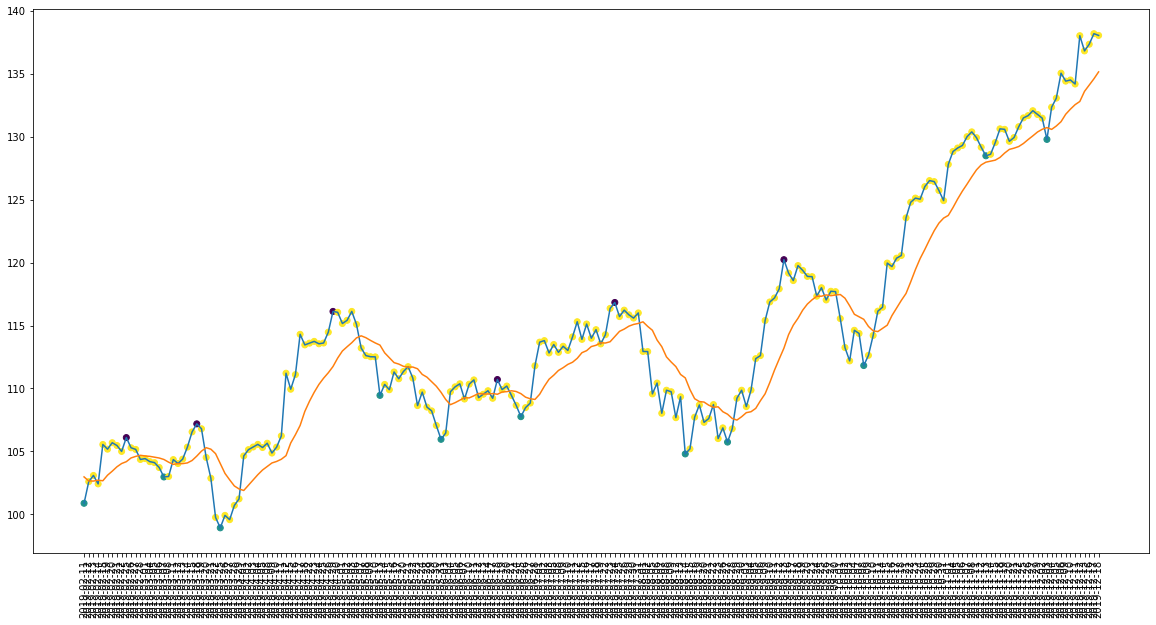

In [226]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [227]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 4
actual holds but predicted buy: 10
actual holds but predicted sell: 30
actual predicted holds: 161
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 80.09950248756219%
actual buys: 11
actual sells: 6
actual holds: 201


In [228]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 84.61538461538461%
Percentage sells correct: 43.75%
Percentage holds correct: 87.20930232558139%


In [229]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $100.87999725341795
Shares owned at the moment: 98
Cash capital at the moment: $86.57310990524456


Price increase from previously bought: 5.963561901624148%
Share price: $107.19000244140624
Shares owned at the moment: 0
Cash capital at the moment: $10562.305643505097


Share price: $98.93000030517578
Shares owned at the moment: 106
Cash capital at the moment: $46.8875160675052


Price increase from previously bought: 5.98570404178993%
Share price: $105.13999938964844
Shares owned at the moment: 0
Cash capital at the moment: $11161.079141548156


Share price: $109.4499969482422
Shares owned at the moment: 101
Cash capital at the moment: $76.22971312331902


Stop Loss Activated!

Share price: $105.95999908447266
Shares owned at the moment: 0
Cash capital at the moment: $10748.759230909345


Share price: $108.4800033569336
Shares owned at the moment: 98
Cash capital at the moment: $88.48354102515987


Stop Loss Activated!

Share price: $104.8000030517578
Shares owned at the 

In [230]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


In [231]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.614679   44.44444444444444%  33.333333333333336%   
1       0.632558                62.5%  33.333333333333336%   
2       0.701835                25.0%  33.333333333333336%   
3       0.725581   8.333333333333334%                40.0%   
4       0.573460                50.0%  33.333333333333336%   
5       0.596244                30.0%                50.0%   
6       0.761468  27.272727272727273%  33.333333333333336%   

        correct_holds     correct_low_buys  correct_high_sells  \
0               63.5%   52.63157894736842%  47.61904761904762%   
1  64.64646464646465%  61.111111111111114%  66.66666666666667%   
2   73.6318407960199%   71.42857142857143%  59.45945945945946%   
3  78.23834196891191%   56.52173913043478%               62.5%   
4  58.76288659793814%   67.44186046511628%  47.72727272727273%   
5   61.6580310880829%   53.65853658536585%  53.65853658536585%   
6  80.09950248756219%   84.61538461538461%              43.75%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0  81.02189781021897%   -5.897446748158945%    -7.30802773938658%  
1  86.76470588235294%  -16.343050759745328%  -48.998182398364555%  
2  85.53459119496856%  -0.6691757968068305%   -5.545324129943856%  
3  86.82634730538922%  -11.902462233216756%   -7.669883276367181%  
4  80.48780487804878%   -21.76057925191646%  -10.879329186439518%  
5  83.07692307692308%    -35.1077277616251%   -41.56249103630067%  
6  87.20930232558139%    12.10056447572706%    35.77290673755644%

### recession

In [232]:
logger = []

In [233]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   136.839996  137.690058 -77.454723  33776700.0     2.0
2020-01-23   136.679993  137.534664 -80.363881  26227600.0     2.0
2020-01-24   136.539993  137.381637 -69.867648  16881900.0     2.0
2020-01-27   133.149994  136.730615 -90.166021   1715500.0     1.0
2020-01-28   132.029999  136.007444 -79.004573 -11145000.0     2.0


In [234]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
# price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [235]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [236]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [237]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [238]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 7ms/step - loss: 0.1280 - accuracy: 0.7534 - mean_squared_error: 2.5717 - weighted_accuracy: 0.7534 - weighted_mean_squared_error: 2.5717
Test loss: 0.12800294160842896
Test accuracy: 0.7534246444702148


In [239]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 183, 0: 27, 1: 9})

In [240]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [241]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)

In [242]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2020-02-11   138.000000  136.179383  -6.410124  26757600.0     0.0   
2020-02-12   138.000000  136.459478  -9.001177  33336200.0     2.0   
2020-02-13   137.880005  136.696481 -13.465502  33336200.0     2.0   
2020-02-14   137.460007  136.878562 -14.718062  25888700.0     2.0   
2020-02-18   135.639999  136.968015 -23.401387  19261100.0     2.0   

            predictions  actual  
Date                             
2020-02-11            2       0  
2020-02-12            0       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-18            2       2

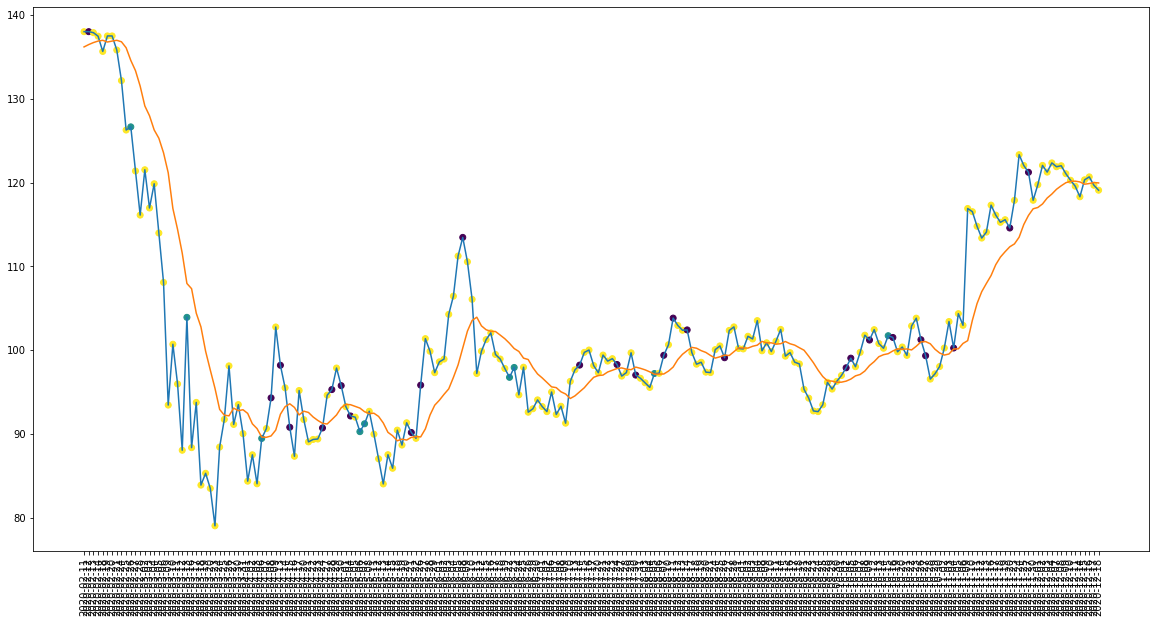

In [243]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

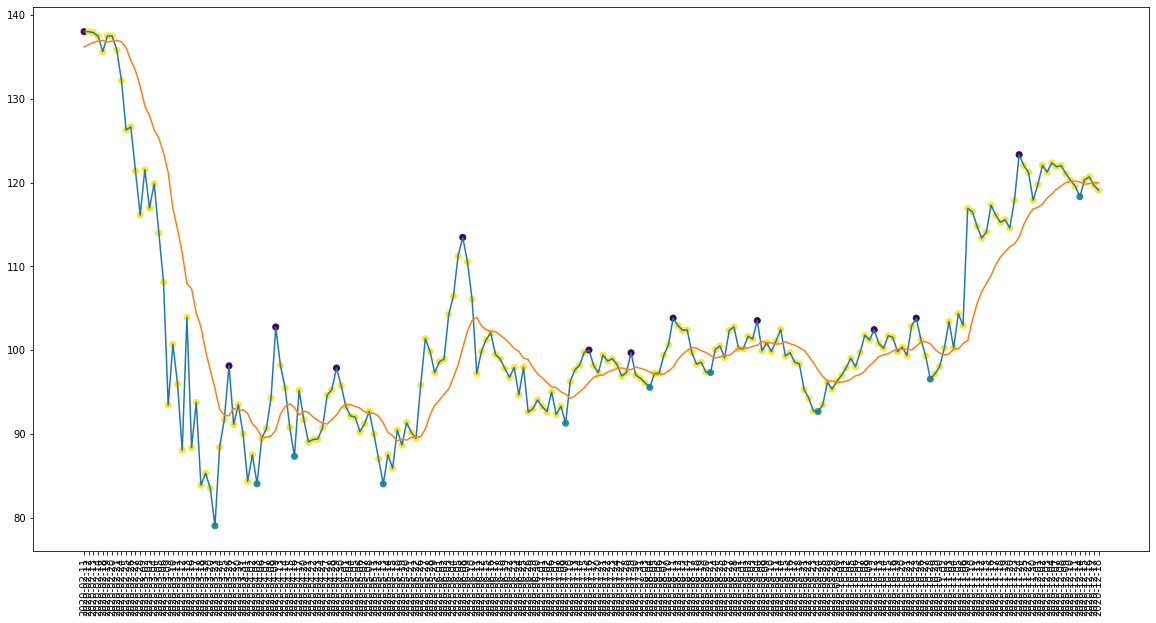

In [244]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [245]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 9
actual holds but predicted sell: 25
actual predicted holds: 163
Percentage buys correct: 0.0%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 82.74111675126903%
actual buys: 10
actual sells: 12
actual holds: 197


In [246]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 48.148148148148145%
Percentage holds correct: 81.86813186813187%


In [247]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $126.63999938964844
Shares owned at the moment: 78
Cash capital at the moment: $94.91576773834277


Stop Loss Activated!

Share price: $121.37000274658205
Shares owned at the moment: 0
Cash capital at the moment: $9535.7421163826


Share price: $103.91000366210938
Shares owned at the moment: 91
Cash capital at the moment: $53.92830471420348


Stop Loss Activated!

Share price: $88.36000061035156
Shares owned at the moment: 0
Cash capital at the moment: $8072.576270103455


Share price: $89.45999908447266
Shares owned at the moment: 89
Cash capital at the moment: $88.74101680946296


Price increase from previously bought: 5.121160511719758%
Share price: $94.3000030517578
Shares owned at the moment: 0
Cash capital at the moment: $8458.36136266899


Share price: $90.2699966430664
Shares owned at the moment: 93
Cash capital at the moment: $40.165123222348484


Stop Loss Activated!

Share price: $87.02999877929688
Shares owned at the moment: 0
Cash capital at the moment: $8111.

In [248]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


In [249]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.614679   44.44444444444444%  33.333333333333336%   
1       0.632558                62.5%  33.333333333333336%   
2       0.701835                25.0%  33.333333333333336%   
3       0.725581   8.333333333333334%                40.0%   
4       0.573460                50.0%  33.333333333333336%   
5       0.596244                30.0%                50.0%   
6       0.761468  27.272727272727273%  33.333333333333336%   
7       0.753425                 0.0%  16.666666666666668%   

        correct_holds     correct_low_buys   correct_high_sells  \
0               63.5%   52.63157894736842%   47.61904761904762%   
1  64.64646464646465%  61.111111111111114%   66.66666666666667%   
2   73.6318407960199%   71.42857142857143%   59.45945945945946%   
3  78.23834196891191%   56.52173913043478%                62.5%   
4  58.76288659793814%   67.44186046511628%   47.72727272727273%   
5   61.6580310880829%   53.65853658536585%   53.65853658536585%   
6  80.09950248756219%   84.61538461538461%               43.75%   
7  82.74111675126903%  33.333333333333336%  48.148148148148145%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0  81.02189781021897%   -5.897446748158945%    -7.30802773938658%  
1  86.76470588235294%  -16.343050759745328%  -48.998182398364555%  
2  85.53459119496856%  -0.6691757968068305%   -5.545324129943856%  
3  86.82634730538922%  -11.902462233216756%   -7.669883276367181%  
4  80.48780487804878%   -21.76057925191646%  -10.879329186439518%  
5  83.07692307692308%    -35.1077277616251%   -41.56249103630067%  
6  87.20930232558139%    12.10056447572706%    35.77290673755644%  
7  81.86813186813187%   -22.56301014511113%   -14.13141708526613%

## American Axle & Manufacturing Holdings, Inc

In [250]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


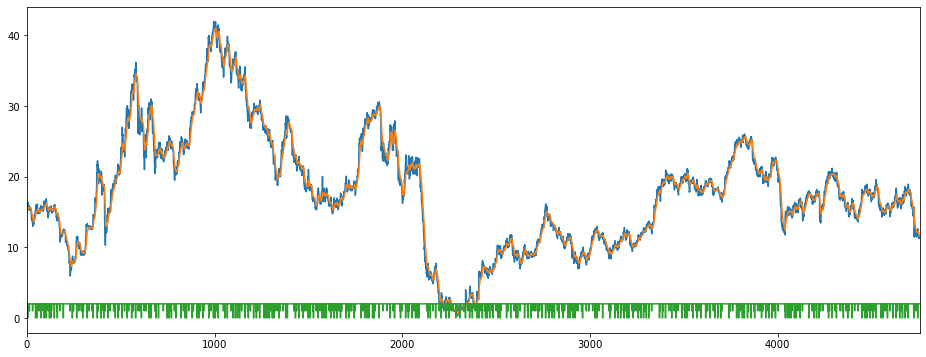

In [251]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [252]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0

In [253]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
# price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [254]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [255]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

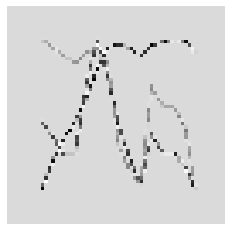

In [256]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [257]:
X = X/255

In [258]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [259]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [260]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [261]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [262]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.3140655105973025, 2: 0.36686962404561707}
Epoch 1/200
30/30 [==============================] - 2s 65ms/step - loss: 0.2457 - accuracy: 0.3720 - mse: 1.6111 - weighted_accuracy: 0.2899 - weighted_mse: 1.6715 - val_loss: 0.2287 - val_accuracy: 0.0485 - val_mse: 0.9817 - val_weighted_accuracy: 0.0485 - val_weighted_mse: 0.9817
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2049 - accuracy: 0.3788 - mse: 1.2028 - weighted_accuracy: 0.3180 - weighted_mse: 1.2001 - val_loss: 0.2076 - val_accuracy: 0.1844 - val_mse: 0.7455 - val_weighted_accuracy: 0.1844 - val_weighted_mse: 0.7455
Epoch 3/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2051 - accuracy: 0.3923 - mse: 1.1661 - weighted_accuracy: 0.3193 - weighted_mse: 1.1751 - val_loss: 0.2209 - val_accuracy: 0.0443 - val_mse: 1.0090 - val_weighted_accuracy: 0.0443 - val_weighted_mse: 1.0090
Epoch 4/200
30/30 [==============================] - 0s 10ms/step - loss: 0.20

30/30 [==============================] - 0s 10ms/step - loss: 0.1988 - accuracy: 0.3462 - mse: 1.1803 - weighted_accuracy: 0.3551 - weighted_mse: 1.1747 - val_loss: 0.2014 - val_accuracy: 0.0706 - val_mse: 0.9177 - val_weighted_accuracy: 0.0706 - val_weighted_mse: 0.9177
Epoch 29/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1973 - accuracy: 0.3243 - mse: 1.1676 - weighted_accuracy: 0.3708 - weighted_mse: 1.1647 - val_loss: 0.1972 - val_accuracy: 0.1170 - val_mse: 0.9229 - val_weighted_accuracy: 0.1170 - val_weighted_mse: 0.9229
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1978 - accuracy: 0.3222 - mse: 1.1881 - weighted_accuracy: 0.3919 - weighted_mse: 1.1838 - val_loss: 0.1994 - val_accuracy: 0.0685 - val_mse: 0.9511 - val_weighted_accuracy: 0.0685 - val_weighted_mse: 0.9511
Epoch 31/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1970 - accuracy: 0.3085 - mse: 1.1931 - weighted_accuracy: 0.3523 - weighted_mse: 1

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1839 - accuracy: 0.2453 - mse: 1.2552 - weighted_accuracy: 0.4860 - weighted_mse: 1.2394 - val_loss: 0.1929 - val_accuracy: 0.1243 - val_mse: 1.0324 - val_weighted_accuracy: 0.1243 - val_weighted_mse: 1.0324
Epoch 58/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1834 - accuracy: 0.2076 - mse: 1.2504 - weighted_accuracy: 0.4667 - weighted_mse: 1.2181 - val_loss: 0.2012 - val_accuracy: 0.0769 - val_mse: 1.2250 - val_weighted_accuracy: 0.0769 - val_weighted_mse: 1.2250
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1842 - accuracy: 0.2131 - mse: 1.2697 - weighted_accuracy: 0.4650 - weighted_mse: 1.2238 - val_loss: 0.1911 - val_accuracy: 0.1475 - val_mse: 1.0597 - val_weighted_accuracy: 0.1475 - val_weighted_mse: 1.0597
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1828 - accuracy: 0.2136 - mse: 1.2757 - weighted_accuracy: 0.4688 - wei

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1665 - accuracy: 0.2013 - mse: 1.4201 - weighted_accuracy: 0.5699 - weighted_mse: 1.3624 - val_loss: 0.1878 - val_accuracy: 0.2118 - val_mse: 1.2694 - val_weighted_accuracy: 0.2118 - val_weighted_mse: 1.2694
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1637 - accuracy: 0.1997 - mse: 1.4038 - weighted_accuracy: 0.5676 - weighted_mse: 1.3702 - val_loss: 0.1916 - val_accuracy: 0.1707 - val_mse: 1.2798 - val_weighted_accuracy: 0.1707 - val_weighted_mse: 1.2798
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1634 - accuracy: 0.2055 - mse: 1.4248 - weighted_accuracy: 0.5570 - weighted_mse: 1.3795 - val_loss: 0.1894 - val_accuracy: 0.1939 - val_mse: 1.3192 - val_weighted_accuracy: 0.1939 - val_weighted_mse: 1.3192
Epoch 89/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1654 - accuracy: 0.1870 - mse: 1.4349 - weighted_accuracy: 0.5630 - wei

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1457 - accuracy: 0.2666 - mse: 1.7774 - weighted_accuracy: 0.6343 - weighted_mse: 1.7438 - val_loss: 0.1911 - val_accuracy: 0.2097 - val_mse: 1.4756 - val_weighted_accuracy: 0.2097 - val_weighted_mse: 1.4756
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1467 - accuracy: 0.2766 - mse: 1.7140 - weighted_accuracy: 0.6415 - weighted_mse: 1.7037 - val_loss: 0.1845 - val_accuracy: 0.3024 - val_mse: 1.4886 - val_weighted_accuracy: 0.3024 - val_weighted_mse: 1.4886
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1481 - accuracy: 0.2750 - mse: 1.7054 - weighted_accuracy: 0.6520 - weighted_mse: 1.6688 - val_loss: 0.1887 - val_accuracy: 0.2561 - val_mse: 1.5346 - val_weighted_accuracy: 0.2561 - val_weighted_mse: 1.5346
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1461 - accuracy: 0.2792 - mse: 1.7563 - weighted_accuracy: 0.6535 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1338 - accuracy: 0.3825 - mse: 2.0179 - weighted_accuracy: 0.6951 - weighted_mse: 2.0467 - val_loss: 0.1879 - val_accuracy: 0.3783 - val_mse: 1.8835 - val_weighted_accuracy: 0.3783 - val_weighted_mse: 1.8835
Epoch 145/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1328 - accuracy: 0.3786 - mse: 2.0542 - weighted_accuracy: 0.6863 - weighted_mse: 2.1018 - val_loss: 0.1746 - val_accuracy: 0.4373 - val_mse: 1.7317 - val_weighted_accuracy: 0.4373 - val_weighted_mse: 1.7317
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1286 - accuracy: 0.4173 - mse: 2.0130 - weighted_accuracy: 0.7133 - weighted_mse: 2.1354 - val_loss: 0.1828 - val_accuracy: 0.4036 - val_mse: 1.8636 - val_weighted_accuracy: 0.4036 - val_weighted_mse: 1.8636
Epoch 147/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1306 - accuracy: 0.4023 - mse: 2.0706 - weighted_accuracy: 0.7115 

Epoch 173/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1213 - accuracy: 0.5153 - mse: 2.3115 - weighted_accuracy: 0.7275 - weighted_mse: 2.5602 - val_loss: 0.1557 - val_accuracy: 0.5764 - val_mse: 1.9508 - val_weighted_accuracy: 0.5764 - val_weighted_mse: 1.9508
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1148 - accuracy: 0.5100 - mse: 2.3252 - weighted_accuracy: 0.7565 - weighted_mse: 2.6850 - val_loss: 0.1679 - val_accuracy: 0.5121 - val_mse: 2.0419 - val_weighted_accuracy: 0.5121 - val_weighted_mse: 2.0419
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1158 - accuracy: 0.5126 - mse: 2.3276 - weighted_accuracy: 0.7410 - weighted_mse: 2.6297 - val_loss: 0.1637 - val_accuracy: 0.5311 - val_mse: 1.9456 - val_weighted_accuracy: 0.5311 - val_weighted_mse: 1.9456
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1183 - accuracy: 0.5190 - mse: 2.2890 - weighted_accuracy: 0.7415 -

In [263]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.13831664621829987
Test accuracy: 0.6775553226470947


In [264]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.5187485  -0.49539232 -0.41965595]
 [-0.22185495 -1.9801669  -0.5305423 ]
 [-3.2240608   0.10208343 -0.8112028 ]
 ...
 [-1.4689521  -0.6705806  -0.2881703 ]
 [-0.6473408  -1.7496614  -0.22291175]
 [-0.54257524 -1.9312041  -0.26326674]]


Counter({2: 671, 0: 120, 1: 158})

In [265]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [266]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 17
actual buys but predicted sell: 2
actual buys but predicted hold: 25
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 31
actual holds but predicted buy: 140
actual holds but predicted sell: 107
actual predicted holds: 615
Percentage buys correct: 38.63636363636363%
Percentage sells correct: 25.58139534883721%
Percentage holds correct: 71.34570765661253%
actual buys: 44
actual sells: 43
actual holds: 862


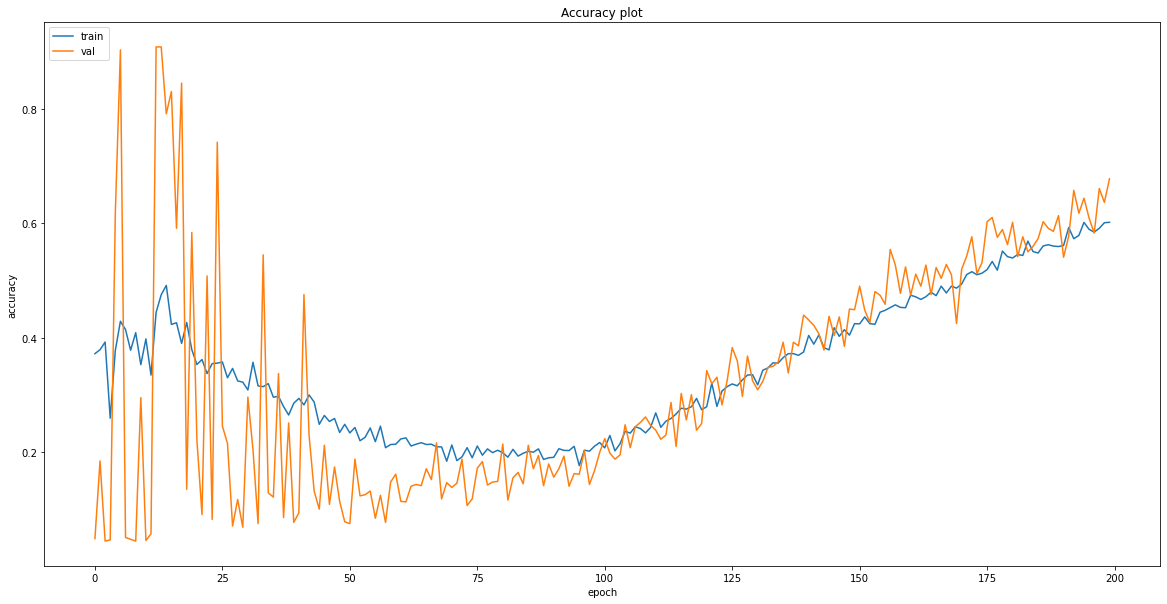

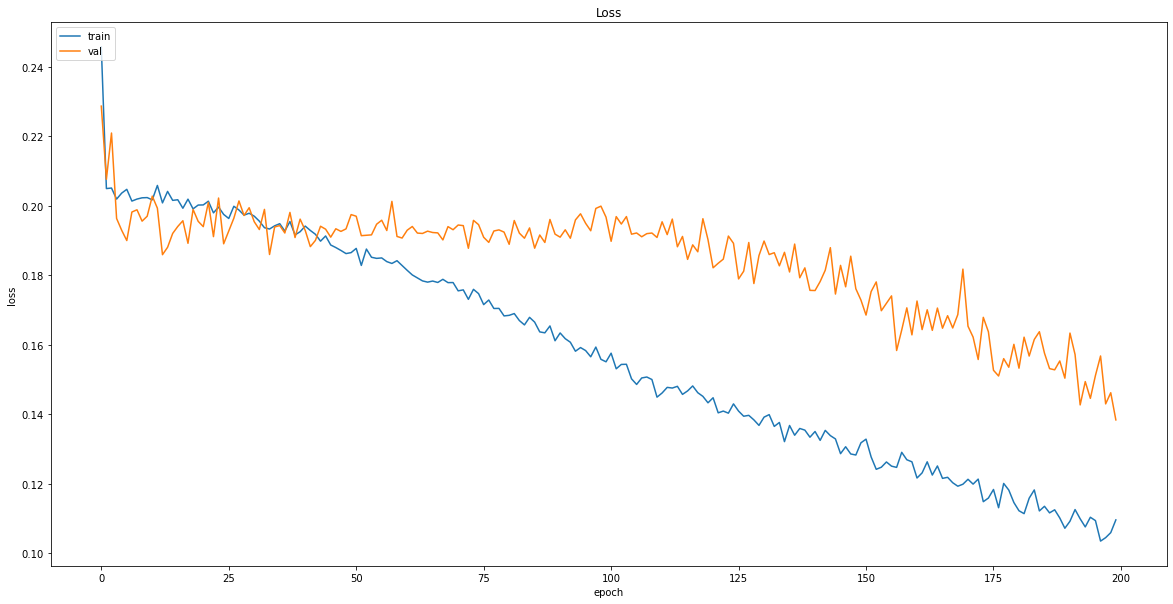

In [267]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [268]:
# Save model
model.save("models/{}".format('axl_image_cnn_buy_hold_sell_no_close.model'))

INFO:tensorflow:Assets written to: models/axl_image_cnn_buy_hold_sell_no_close.model\assets


### Test Performance

### non-recession

In [269]:
logger = []

In [270]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        14.61  13.028180  -0.258404  23356600.0     2.0
2019-01-23        14.52  13.257691  -3.886001  21174700.0     2.0
2019-01-24        14.18  13.399585 -13.535906  19629300.0     2.0
2019-01-25        14.38  13.550418  -8.579880  20903300.0     2.0
2019-01-28        14.71  13.728815  -4.790414  22287500.0     2.0


In [271]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
# price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [272]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [273]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
X = X/255
y = np.array(y)

In [274]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [275]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 2ms/step - loss: 0.1481 - accuracy: 0.6697 - mean_squared_error: 2.2401 - weighted_accuracy: 0.6697 - weighted_mean_squared_error: 2.2401
Test loss: 0.1481030136346817
Test accuracy: 0.6697247624397278


In [276]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 35, 2: 160, 0: 23})

In [277]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [278]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)

In [279]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        14.01  14.312907 -83.060094  17347800.0     2.0   
2019-02-12        14.34  14.266306 -68.852439  19189100.0     2.0   
2019-02-13        14.45  14.277643 -50.819664  21493700.0     2.0   
2019-02-14        14.70  14.304160 -44.808757  23008200.0     2.0   
2019-02-15        16.83  14.365058 -31.147561  25735200.0     2.0   

            predictions  actual  
Date                             
2019-02-11            1       2  
2019-02-12            1       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            2       2

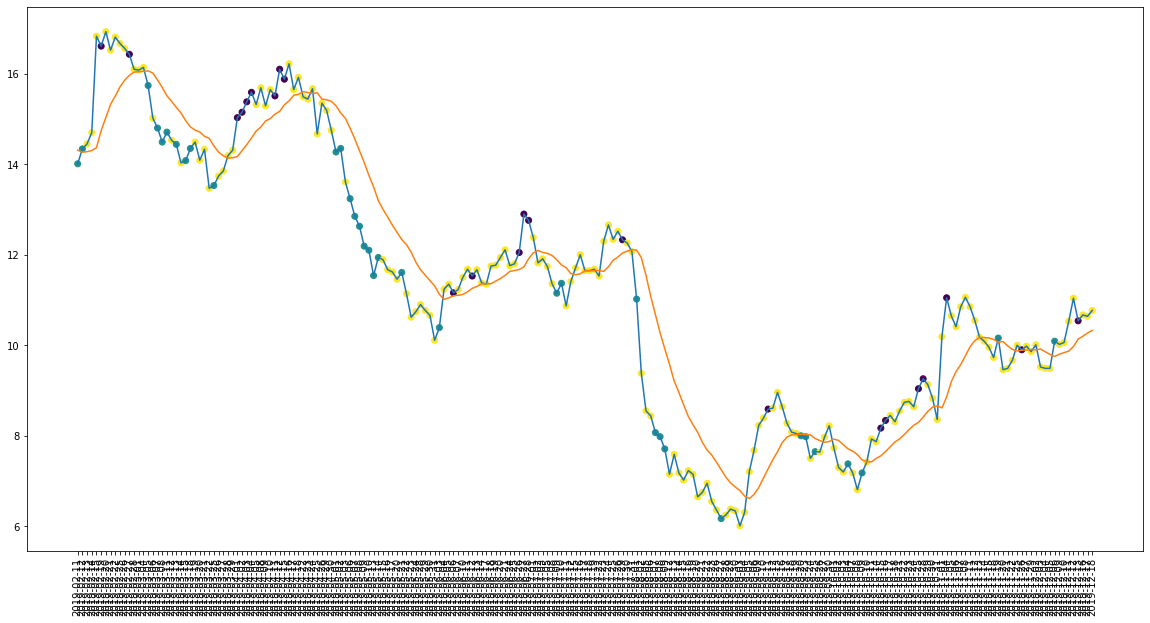

In [280]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

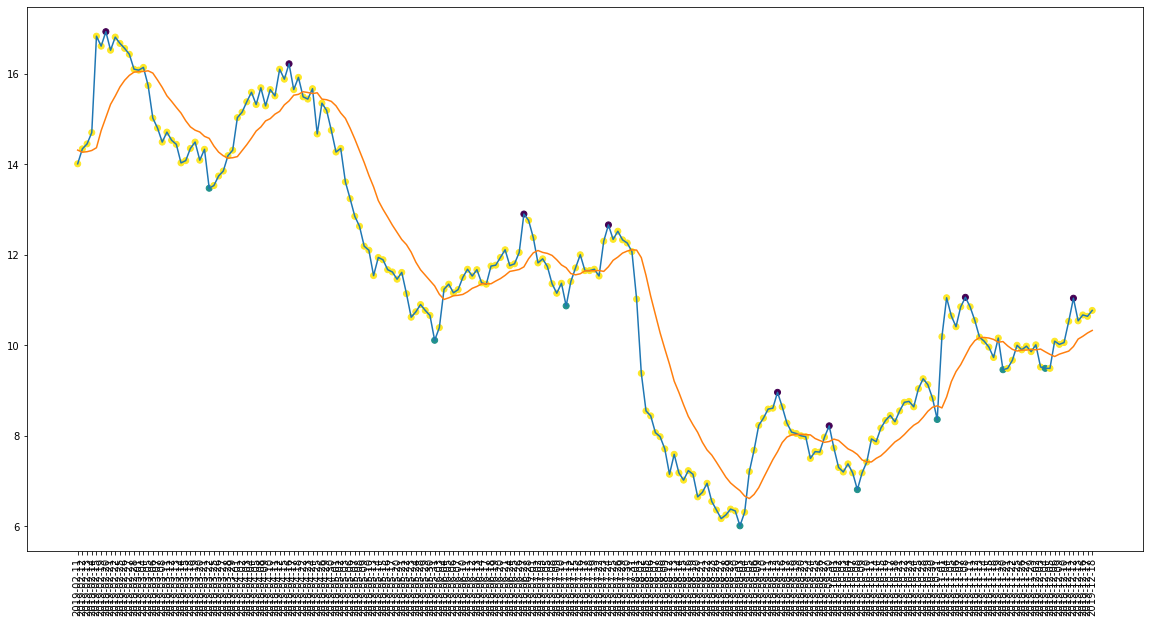

In [281]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [282]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 35
actual holds but predicted sell: 22
actual predicted holds: 145
Percentage buys correct: 0.0%
Percentage sells correct: 12.5%
Percentage holds correct: 71.78217821782178%
actual buys: 8
actual sells: 8
actual holds: 202


In [283]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 40.0%
Percentage sells correct: 60.869565217391305%
Percentage holds correct: 83.01886792452831%


In [284]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.010000228881836
Shares owned at the moment: 711
Cash capital at the moment: $11.496784317492711


Price increase from previously bought: 18.233034309065022%
Share price: $16.610000610351562
Shares owned at the moment: 0
Cash capital at the moment: $11788.730514584064


Share price: $15.739999771118164
Shares owned at the moment: 746
Cash capital at the moment: $14.400075799463593


Stop Loss Activated!

Share price: $15.020000457763672
Shares owned at the moment: 0
Cash capital at the moment: $11188.506886352061


Share price: $14.800000190734865
Shares owned at the moment: 753
Cash capital at the moment: $13.459642333742522


Stop Loss Activated!

Share price: $14.029999732971193
Shares owned at the moment: 0
Cash capital at the moment: $10548.996819314001


Share price: $14.079999923706055
Shares owned at the moment: 747
Cash capital at the moment: $2.313036462304808


Stop Loss Activated!

Share price: $13.470000267028807
Shares owned at the moment: 0
Cash capital a

In [285]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


In [286]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.614679   44.44444444444444%  33.333333333333336%   
1       0.632558                62.5%  33.333333333333336%   
2       0.701835                25.0%  33.333333333333336%   
3       0.725581   8.333333333333334%                40.0%   
4       0.573460                50.0%  33.333333333333336%   
5       0.596244                30.0%                50.0%   
6       0.761468  27.272727272727273%  33.333333333333336%   
7       0.753425                 0.0%  16.666666666666668%   
8       0.669725                 0.0%                12.5%   

        correct_holds     correct_low_buys   correct_high_sells  \
0               63.5%   52.63157894736842%   47.61904761904762%   
1  64.64646464646465%  61.111111111111114%   66.66666666666667%   
2   73.6318407960199%   71.42857142857143%   59.45945945945946%   
3  78.23834196891191%   56.52173913043478%                62.5%   
4  58.76288659793814%   67.44186046511628%   47.72727272727273%   
5   61.6580310880829%   53.65853658536585%   53.65853658536585%   
6  80.09950248756219%   84.61538461538461%               43.75%   
7  82.74111675126903%  33.333333333333336%  48.148148148148145%   
8  71.78217821782178%                40.0%  60.869565217391305%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0  81.02189781021897%   -5.897446748158945%    -7.30802773938658%  
1  86.76470588235294%  -16.343050759745328%  -48.998182398364555%  
2  85.53459119496856%  -0.6691757968068305%   -5.545324129943856%  
3  86.82634730538922%  -11.902462233216756%   -7.669883276367181%  
4  80.48780487804878%   -21.76057925191646%  -10.879329186439518%  
5  83.07692307692308%    -35.1077277616251%   -41.56249103630067%  
6  87.20930232558139%    12.10056447572706%    35.77290673755644%  
7  81.86813186813187%   -22.56301014511113%   -14.13141708526613%  
8  83.01886792452831%   -5.645408558067211%  -23.520909336075793%

### recession

In [287]:
logger = []

In [288]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         9.39  9.715390 -73.059349 -3592400.0     2.0
2020-01-23         9.34  9.657637 -75.342463 -4550300.0     2.0
2020-01-24         9.50  9.633386 -65.000010 -3092000.0     2.0
2020-01-27         9.31  9.583634 -66.883101 -4332600.0     2.0
2020-01-28         9.39  9.553844 -61.688301 -2300800.0     2.0


In [289]:
willr_data = []
# price_data = []
ema_data = []
obv_data = []
labels = []
# data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        # data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        # price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        # data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        # data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
# price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [290]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    # k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    #ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [291]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [292]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [293]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 2ms/step - loss: 0.1356 - accuracy: 0.7260 - mean_squared_error: 2.0922 - weighted_accuracy: 0.7260 - weighted_mean_squared_error: 2.0922
Test loss: 0.1356063187122345
Test accuracy: 0.7260273694992065


In [294]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 169, 0: 19, 1: 31})

In [295]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [296]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)

In [297]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-11         9.84  9.643918 -57.638900 -3274300.0     2.0            2   
2020-02-12        10.34  9.674085 -36.805548 -1876100.0     0.0            0   
2020-02-13        10.22  9.776533 -16.568036  -291400.0     2.0            2   
2020-02-14         8.77  9.844759 -23.668622 -1567700.0     2.0            2   
2020-02-18         8.27  9.679411 -90.686248 -6644000.0     2.0            2   

            actual  
Date                
2020-02-11       2  
2020-02-12       0  
2020-02-13       2  
2020-02-14       2  
2020-02-18       2

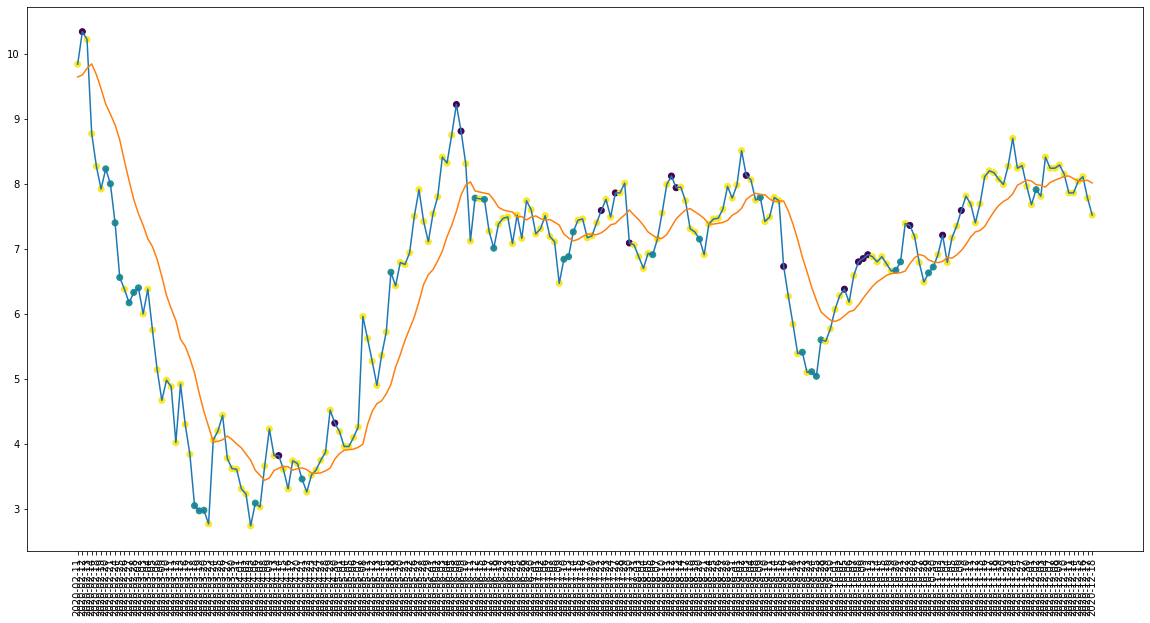

In [298]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

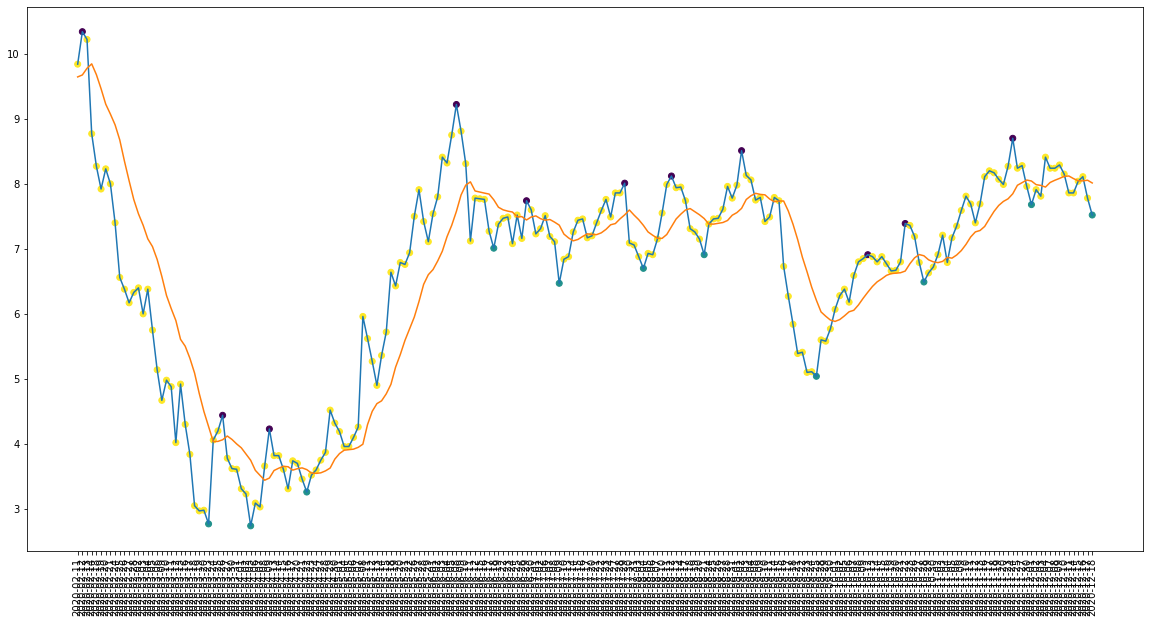

In [299]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [300]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 29
actual holds but predicted sell: 15
actual predicted holds: 153
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 36.36363636363637%
Percentage holds correct: 77.66497461928934%
actual buys: 11
actual sells: 11
actual holds: 197


In [301]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 58.064516129032256%
Percentage sells correct: 89.47368421052632%
Percentage holds correct: 83.92857142857143%


In [302]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.229999542236326
Shares owned at the moment: 1211
Cash capital at the moment: $6.062598376274764


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9667.420598376275


Share price: $8.0
Shares owned at the moment: 1205
Cash capital at the moment: $0.9105983762747201


Stop Loss Activated!

Share price: $7.400000095367432
Shares owned at the moment: 0
Cash capital at the moment: $8893.388962978006


Share price: $7.400000095367432
Shares owned at the moment: 1198
Cash capital at the moment: $3.80954841363382


Stop Loss Activated!

Share price: $6.559999942779541
Shares owned at the moment: 0
Cash capital at the moment: $7841.0775600520365


Share price: $6.559999942779541
Shares owned at the moment: 1192
Cash capital at the moment: $0.05394844639158691


Stop Loss Activated!

Share price: $6.380000114440918
Shares owned at the moment: 0
Cash capital at the moment: $7584.100444484829


Share price: $6.170000076293945
Share

In [303]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%


In [304]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.614679   44.44444444444444%  33.333333333333336%   
1       0.632558                62.5%  33.333333333333336%   
2       0.701835                25.0%  33.333333333333336%   
3       0.725581   8.333333333333334%                40.0%   
4       0.573460                50.0%  33.333333333333336%   
5       0.596244                30.0%                50.0%   
6       0.761468  27.272727272727273%  33.333333333333336%   
7       0.753425                 0.0%  16.666666666666668%   
8       0.669725                 0.0%                12.5%   
9       0.726027  18.181818181818183%   36.36363636363637%   

        correct_holds     correct_low_buys   correct_high_sells  \
0               63.5%   52.63157894736842%   47.61904761904762%   
1  64.64646464646465%  61.111111111111114%   66.66666666666667%   
2   73.6318407960199%   71.42857142857143%   59.45945945945946%   
3  78.23834196891191%   56.52173913043478%                62.5%   
4  58.76288659793814%   67.44186046511628%   47.72727272727273%   
5   61.6580310880829%   53.65853658536585%   53.65853658536585%   
6  80.09950248756219%   84.61538461538461%               43.75%   
7  82.74111675126903%  33.333333333333336%  48.148148148148145%   
8  71.78217821782178%                40.0%  60.869565217391305%   
9  77.66497461928934%  58.064516129032256%   89.47368421052632%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0  81.02189781021897%   -5.897446748158945%    -7.30802773938658%  
1  86.76470588235294%  -16.343050759745328%  -48.998182398364555%  
2  85.53459119496856%  -0.6691757968068305%   -5.545324129943856%  
3  86.82634730538922%  -11.902462233216756%   -7.669883276367181%  
4  80.48780487804878%   -21.76057925191646%  -10.879329186439518%  
5  83.07692307692308%    -35.1077277616251%   -41.56249103630067%  
6  87.20930232558139%    12.10056447572706%    35.77290673755644%  
7  81.86813186813187%   -22.56301014511113%   -14.13141708526613%  
8  83.01886792452831%   -5.645408558067211%  -23.520909336075793%  
9  83.92857142857143%  -3.8244360024220985%   -23.98520794264914%

In [305]:
experiment

'No closing price CNN Images Experiments - cyclic'

In [306]:
log.to_csv('{}.csv'.format(experiment))